# Scanpy: Core plotting functions

https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html

（更新日:2020-12-29）

Scanpyでは、tSNE、UMAP、その他いくつかの次元削減を用いた散布図を`sc.pl.tsne`、`sc.pl.umap`などの関数を使って簡単に作成することができます。

これらの関数は`adata.obsm`に保存されているデータにアクセスします。
例えば、`sc.pl.umap`は`adata.obsm['X_umap']`に保存されている情報を使用します。
より柔軟性を高めるために、`adata.obsm`に格納されている任意のキーを汎用関数`sc.pl.embedding`で使用することができます。

In [ ]:
# Google Colabで実行する場合は まずScanpyインストール
!pip install seaborn scikit-learn statsmodels numba python-igraph louvain leidenalg scanpy

In [ ]:
import scanpy as sc
import pandas as pd
from matplotlib import rcParams

sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.5 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.3


## Load pbmc dataset

In [ ]:
pbmc = sc.datasets.pbmc68k_reduced()
pbmc

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Visualization of gene expression and other variables

散布図ではプロットする値が`color`引数として与えられます。
これは、任意の遺伝子または`.obs`の任意の列を指定することができます。

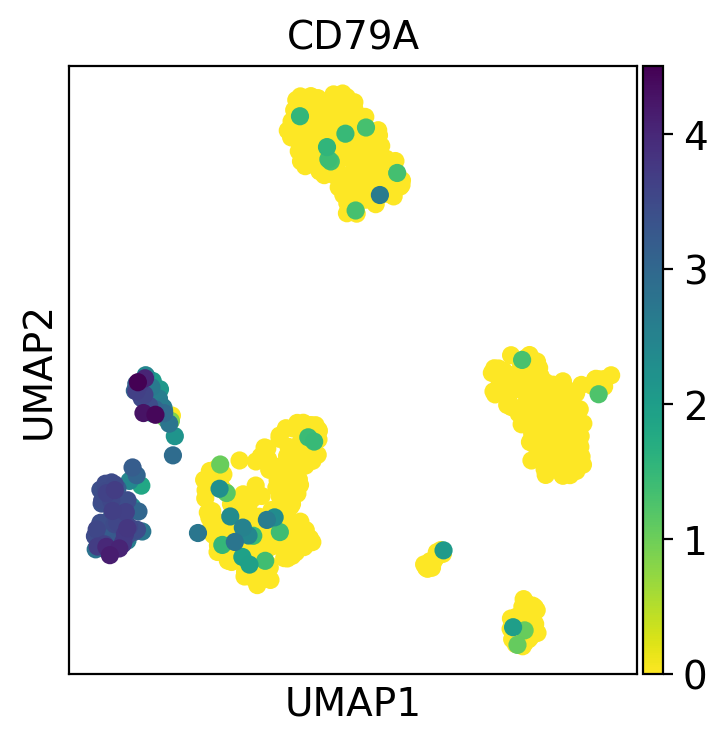

In [ ]:
# rcParams is used for the figure size, in this case 4x4
rcParams['figure.figsize'] = 4, 4
sc.pl.umap(pbmc, color='CD79A')

- `color`引数には複数の値を指定することができます。下の例では、4つの遺伝子をプロットします。
- また、他の2つの値をプロットします：`n_count`は、細胞あたりのUMIカウント数（`.obs`に保存されています）で、`bulk_labels`は、10Xで得られた細胞群の元のラベル付け（クラスタ名？）を示すカテゴリ値です。
- 行ごとのプロット数は `ncols` パラメータで変更します。
- スケールの最大値・最小値は `vmax`, `vmin` で変更します。この例では`vmax`に99パーセンタイルを意味する`p99`を使用します。

     - 複数のプロットに対して個別に`vmax`を設定したい場合は、数値または数値のリストにすることができます。

また、プロットの周りのボックスを削除するために `frameon=False` を使用し、ドットサイズを設定するために s=50 を使用しています。

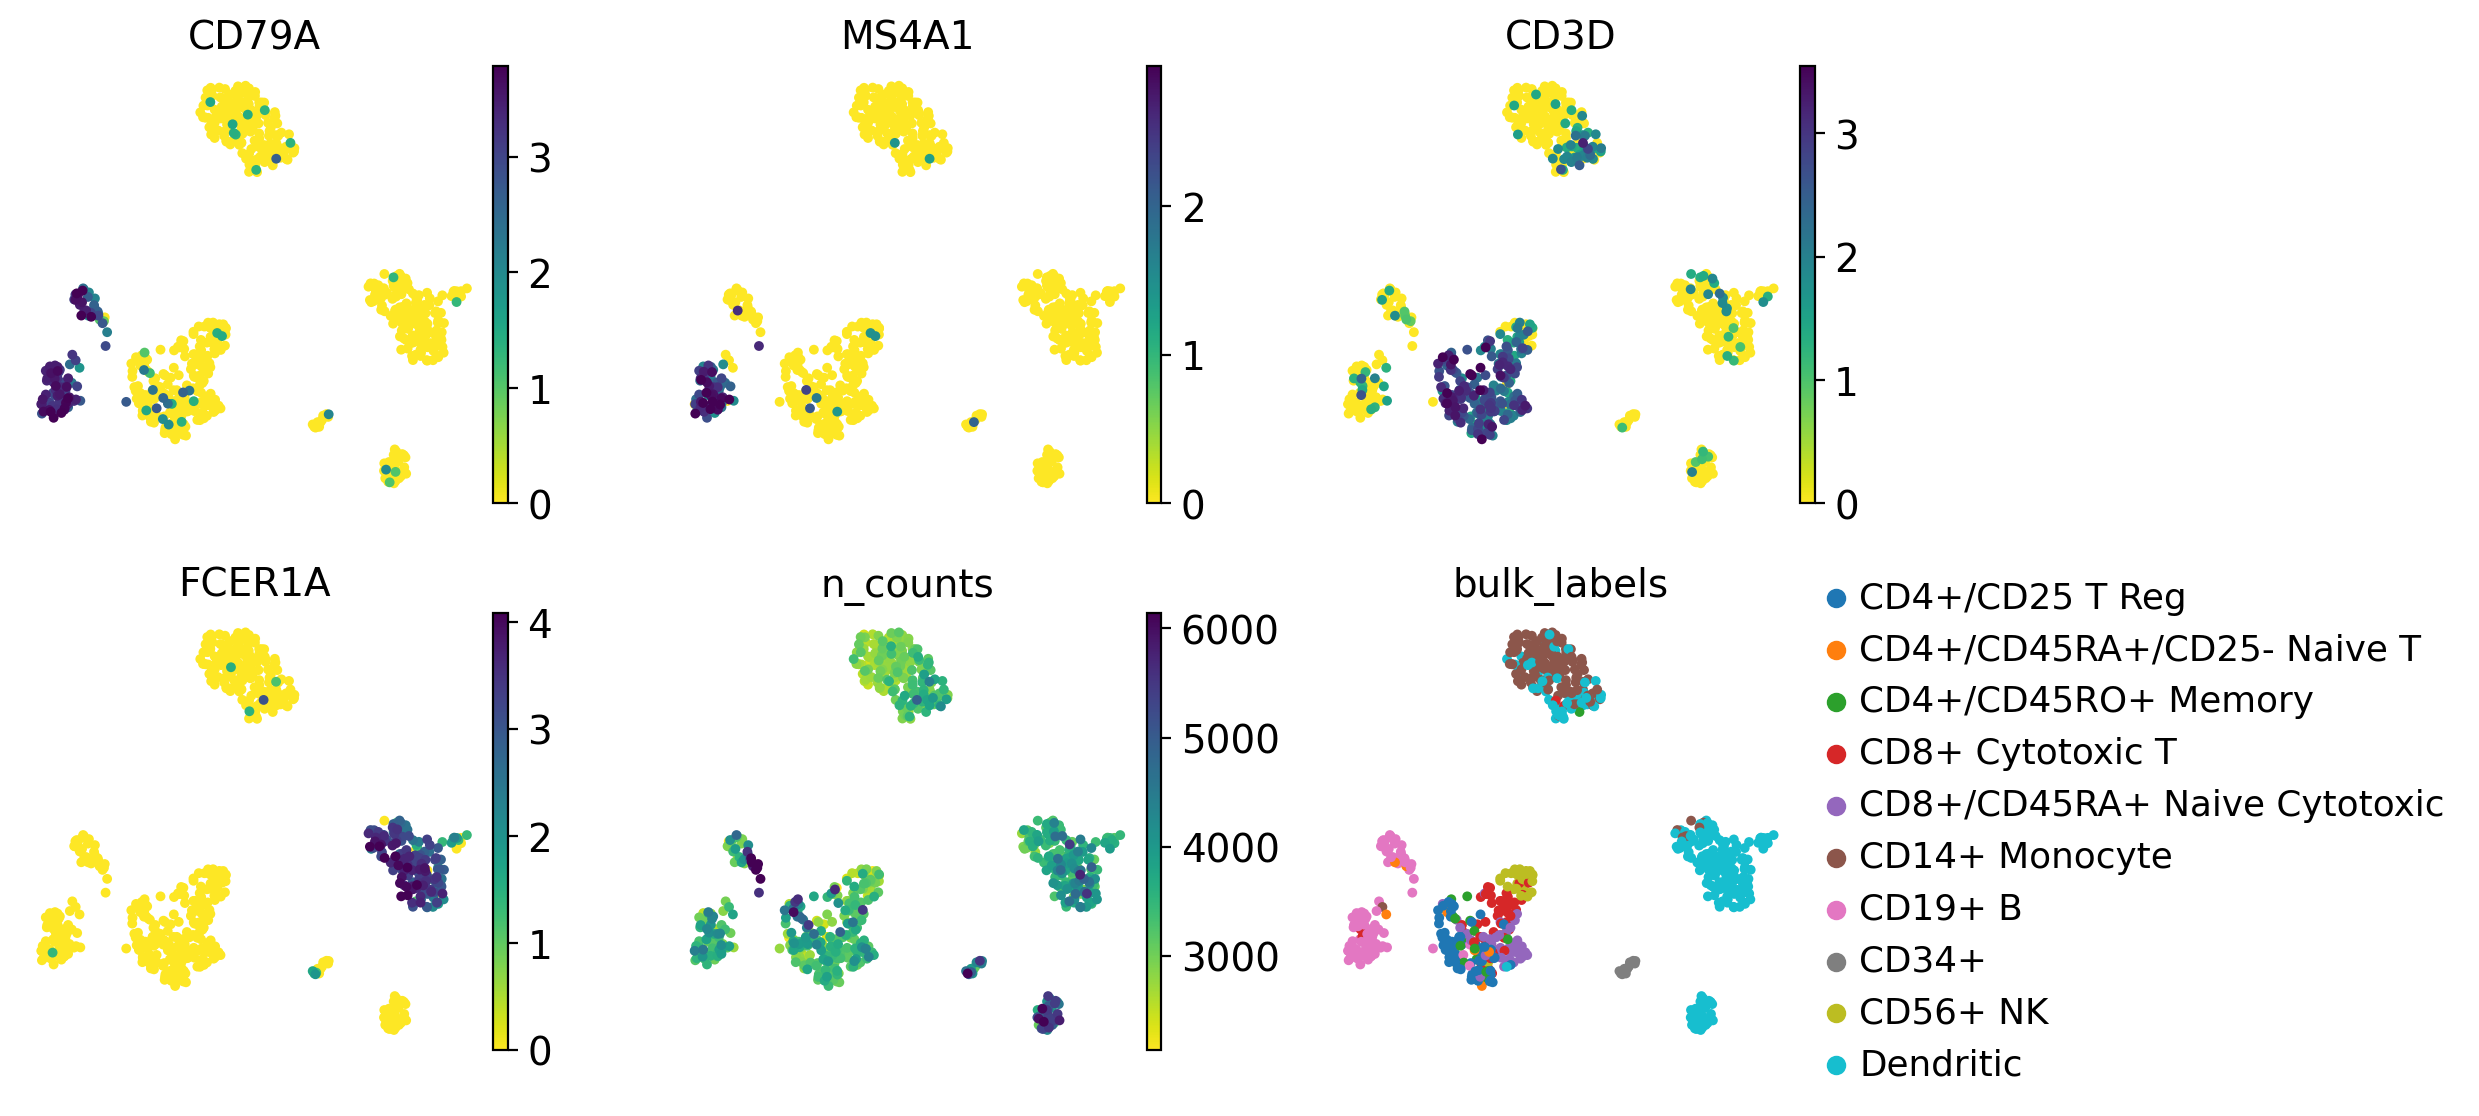

In [ ]:
rcParams['figure.figsize'] = 3,3
sc.pl.umap(pbmc, 
           color=['CD79A', 'MS4A1', 'CD3D', 'FCER1A', 'n_counts', 'bulk_labels'],
           s=50, 
           frameon=False, 
           ncols=3,
           vmax='p99')

このプロットでは、マーカー遺伝子を発現する細胞のグループと、元の細胞ラベルを比較することができます。

散布図のための関数には、画像の微調整を可能にする多くのオプションがあります。例えば、以下のようにクラスタリングを表示することができます。

In [ ]:
# compute clusters using the leiden method and store the results with the name `clusters`
sc.tl.leiden(pbmc, key_added='clusters', resolution=0.5)

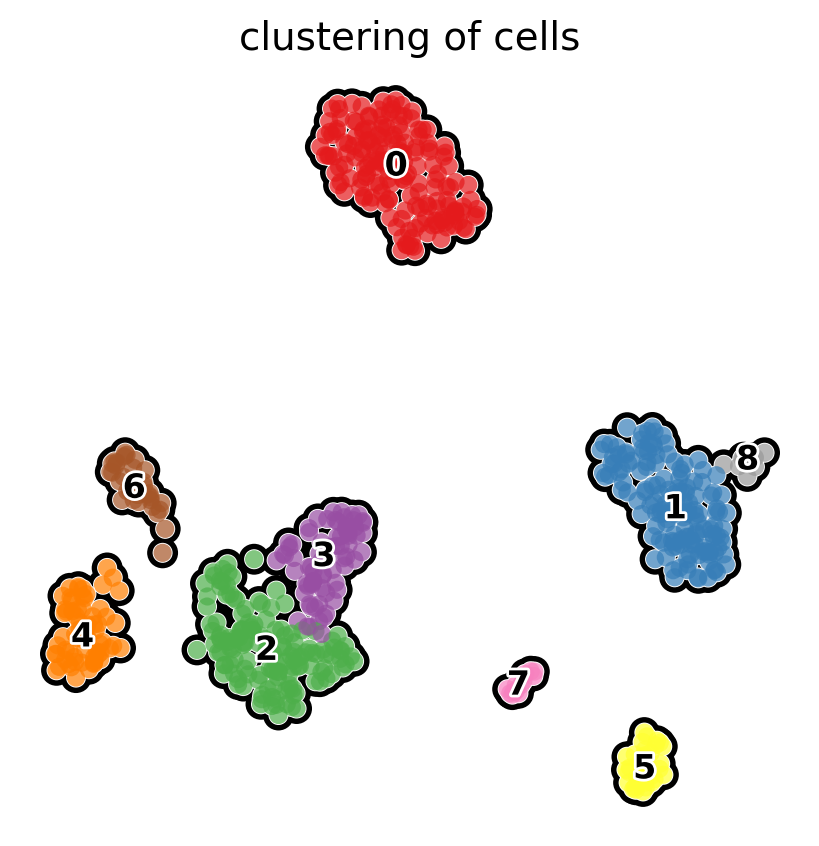

In [ ]:
rcParams['figure.figsize'] = 5, 5
sc.pl.umap(pbmc, color='clusters', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set1')

## Identification of clusters based on known marker genes


- 通常、得られたクラスターはよく知られたマーカー遺伝子を用いてラベル付けする必要があります。
- 散布図を使用すると、遺伝子の発現を見ることができ、おそらくそれをクラスターに関連付けることができます。
- ここでは、ドットプロット、バイオリンプロット、ヒートマップ、そしてトラックプロットを用いて、マーカー遺伝子をクラスターに関連付ける他の可視化手法を紹介します。これらの可視化はすべて同じ情報を要約したものです。
- 最良の結果の選択は研究者の判断に委ねられています。

最初に、マーカー遺伝子の辞書を設定します。これにより、Scanpyが遺伝子のグループを自動的にラベル付けできるようになります。

In [ ]:
marker_genes_dict = {'NK': ['GNLY', 'NKG7'],
                     'T-cell': ['CD3D'],
                     'B-cell': ['CD79A', 'MS4A1'],
                     'Monocytes': ['FCGR3A'],
                     'Dendritic': ['FCER1A']}

### dotplot

- クラスターごとのマーカー遺伝子の発現をチェックする簡単な方法は、ドットプロットを使用することです。
- このタイプのプロットは2種類の情報を要約しています：色は各カテゴリー（この場合は各クラスター内）内の平均発現を表し、ドットサイズは遺伝子を発現しているカテゴリー内の細胞の割合を示します。
- また、グラフに系統樹を追加して類似のクラスタをまとめることも有用です。階層化クラスタリングは、クラスタ間のPCA成分の相関を用いて自動的に計算されます。

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


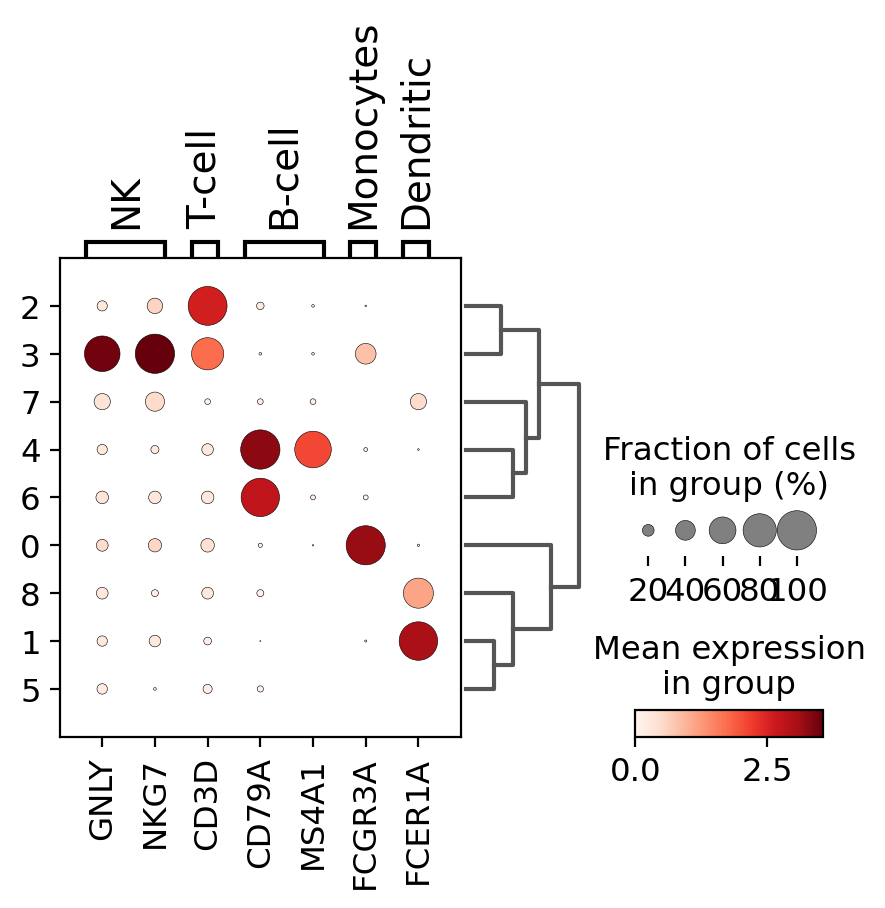

In [ ]:
sc.pl.dotplot(pbmc, marker_genes_dict, 'clusters', dendrogram=True)

このプロットを使用すると、クラスター5と9はB細胞、クラスター2と4はT細胞などに対応していることがわかります。

この情報を利用して、以下のように手動で細胞にアノテーションを付けることができます。

In [ ]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Monocyte',
     '1': 'Dendritic',
     '2': 'T-cell',
     '3': 'NK',
     '4': 'T-cell',
     '5': 'B-cell',
     '6': 'Monocytes',
     '7': 'Dendritic',
     '8': 'other',
     '9': 'B-cell',
     '10': 'other',
     '11': 'Dendritic'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
pbmc.obs['cell type'] = pbmc.obs['clusters'].map(cluster2annotation).astype('category')

categories: B-cell, Dendritic, Monocyte, etc.
var_group_labels: NK, T-cell, B-cell, etc.


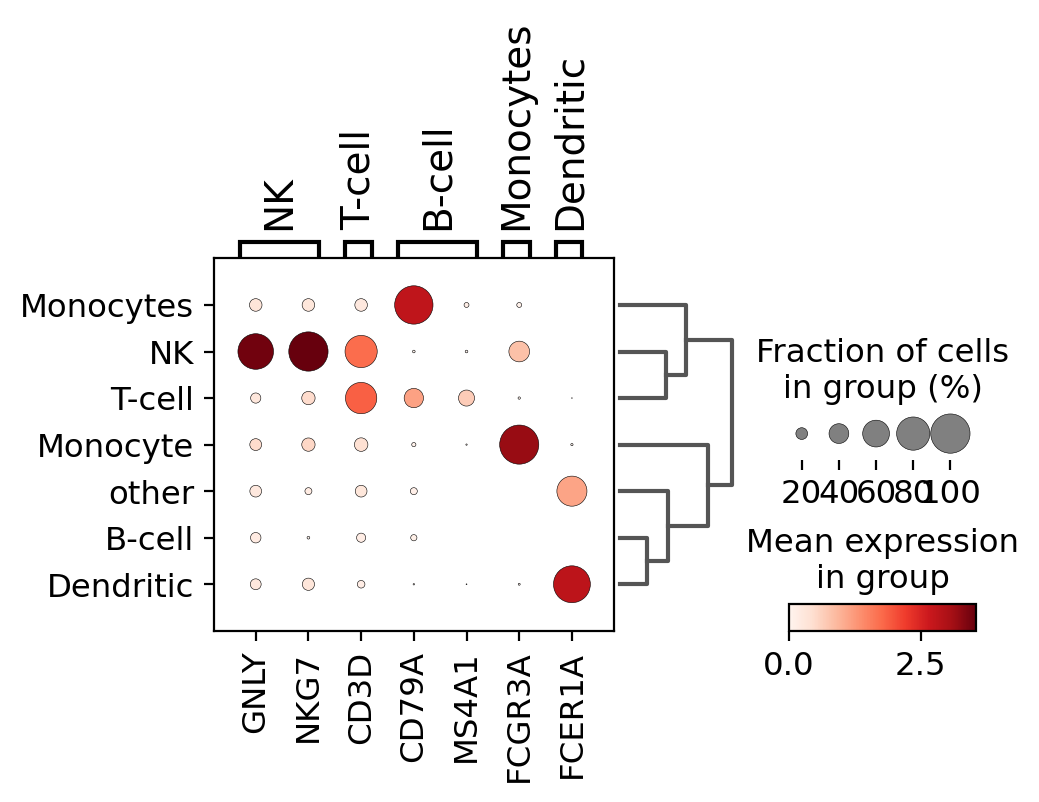

In [ ]:
sc.pl.dotplot(pbmc, marker_genes_dict, 'cell type', dendrogram=True)

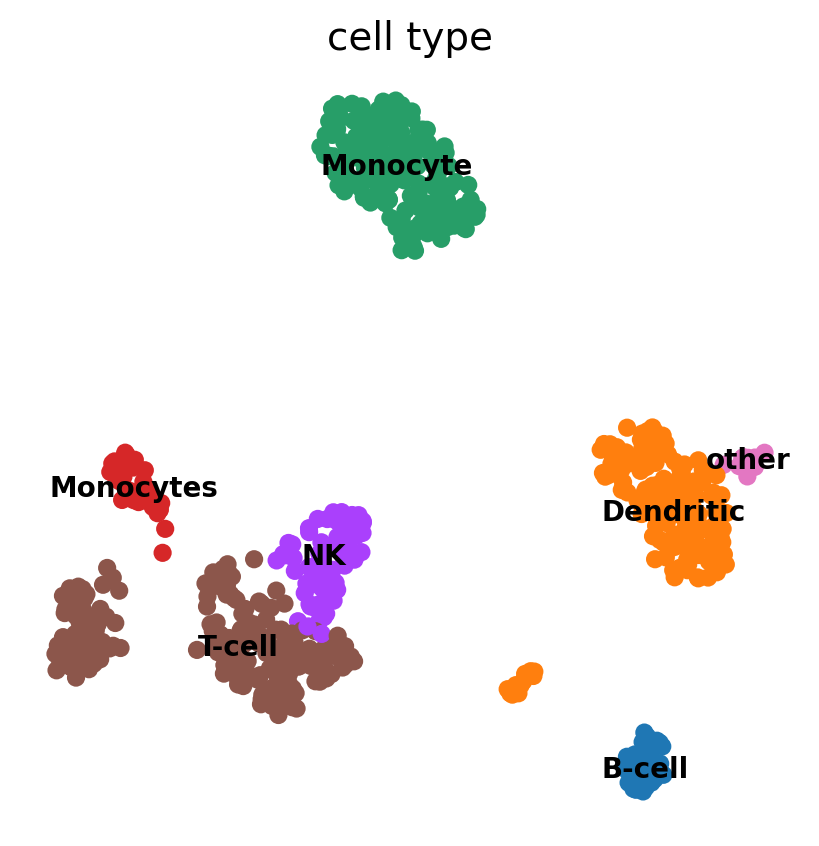

In [ ]:
sc.pl.umap(pbmc, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=10)

### violin plot

マーカーを探索する別の方法として、バイオリンプロットがあります。ここでは、クラスター5と8のCD79Aとクラスター5のMS4A1の発現を見ることができます。ドットプロットと比較して、バイオリンプロットは、細胞間の遺伝子発現値の分布のアイデアを与えてくれます。

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

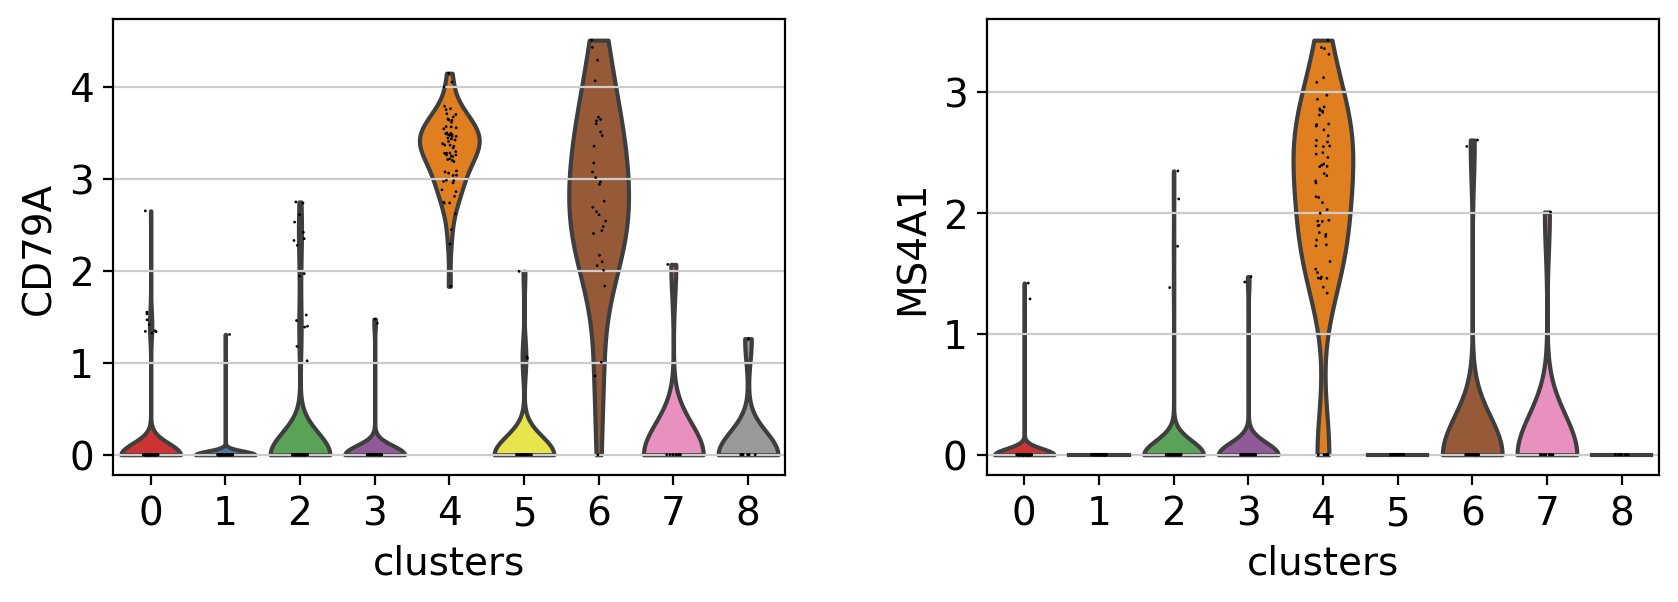

In [ ]:
rcParams['figure.figsize'] = 4.5,3
sc.pl.violin(pbmc, ['CD79A', 'MS4A1'], groupby='clusters' )

注： バイオリンプロットは、`.obs`に格納されている任意の数値をプロットするために使用することもできます。例えば、ここではバイオリンプロットを用いて、異なるクラスタ間の発現遺伝子数とミトコンドリア遺伝子の割合を比較しています。

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


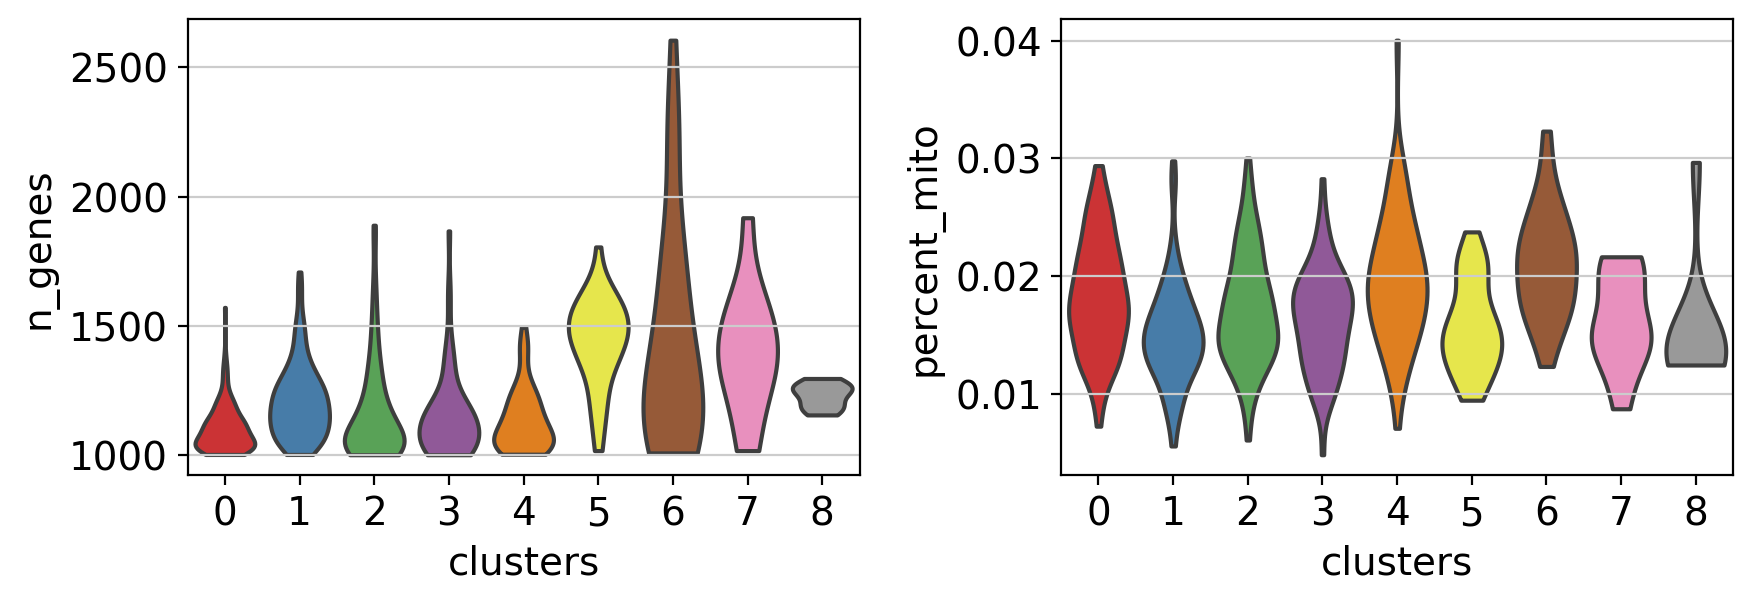

In [ ]:
sc.pl.violin(pbmc, ['n_genes', 'percent_mito'], 
             groupby='clusters', 
             stripplot=False)  # use stripplot=False to remove the internal dots

## stacked-violin plot

すべてのマーカー遺伝子のバイオリンプロットを同時に見るために、`sc.pl.stacked_violin`を使用します。
前述のように、類似したクラスタをグループ化するために系統樹が追加されました。

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


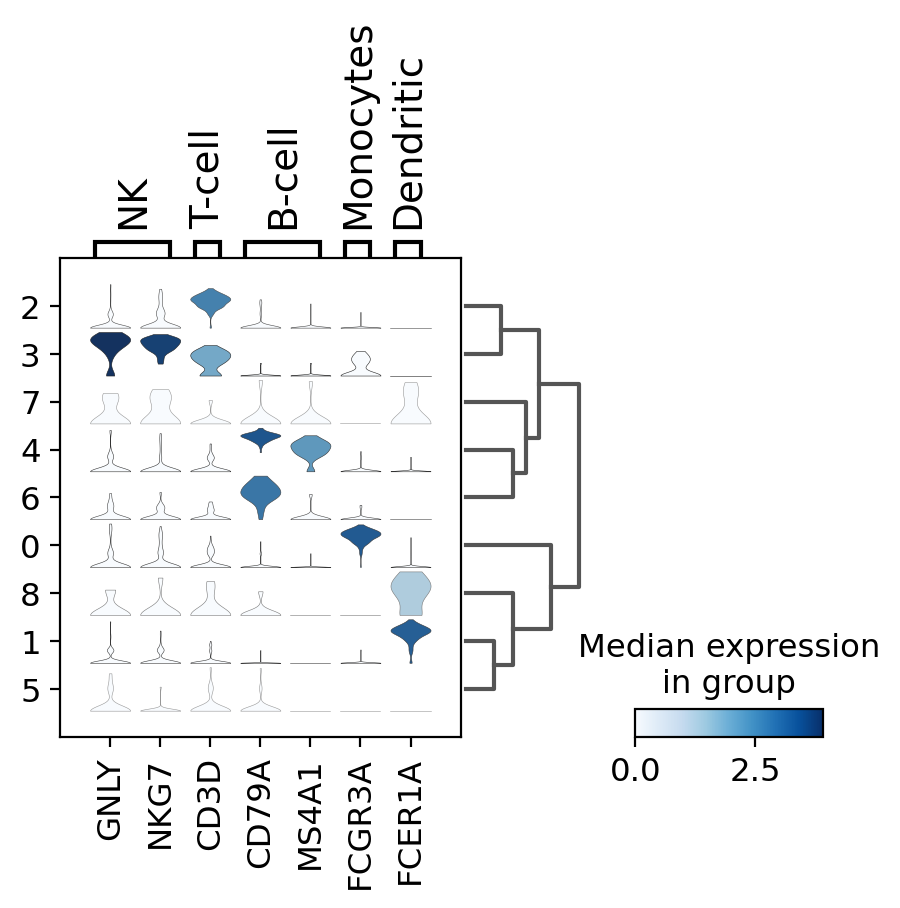

In [ ]:
ax = sc.pl.stacked_violin(pbmc, marker_genes_dict, groupby='clusters', swap_axes=False, dendrogram=True)

## matrixplot

遺伝子の発現を可視化する簡単な方法はmatrixplotです。これは、カテゴリーごとにグループ化された遺伝子ごとの平均発現値のヒートマップです。このタイプのプロットは、基本的にはドットプロットの色と同じ情報を表示します。

ここでは、遺伝子の発現を0から1の間でスケールし、平均発現の最大値を0、最小値を0としています。

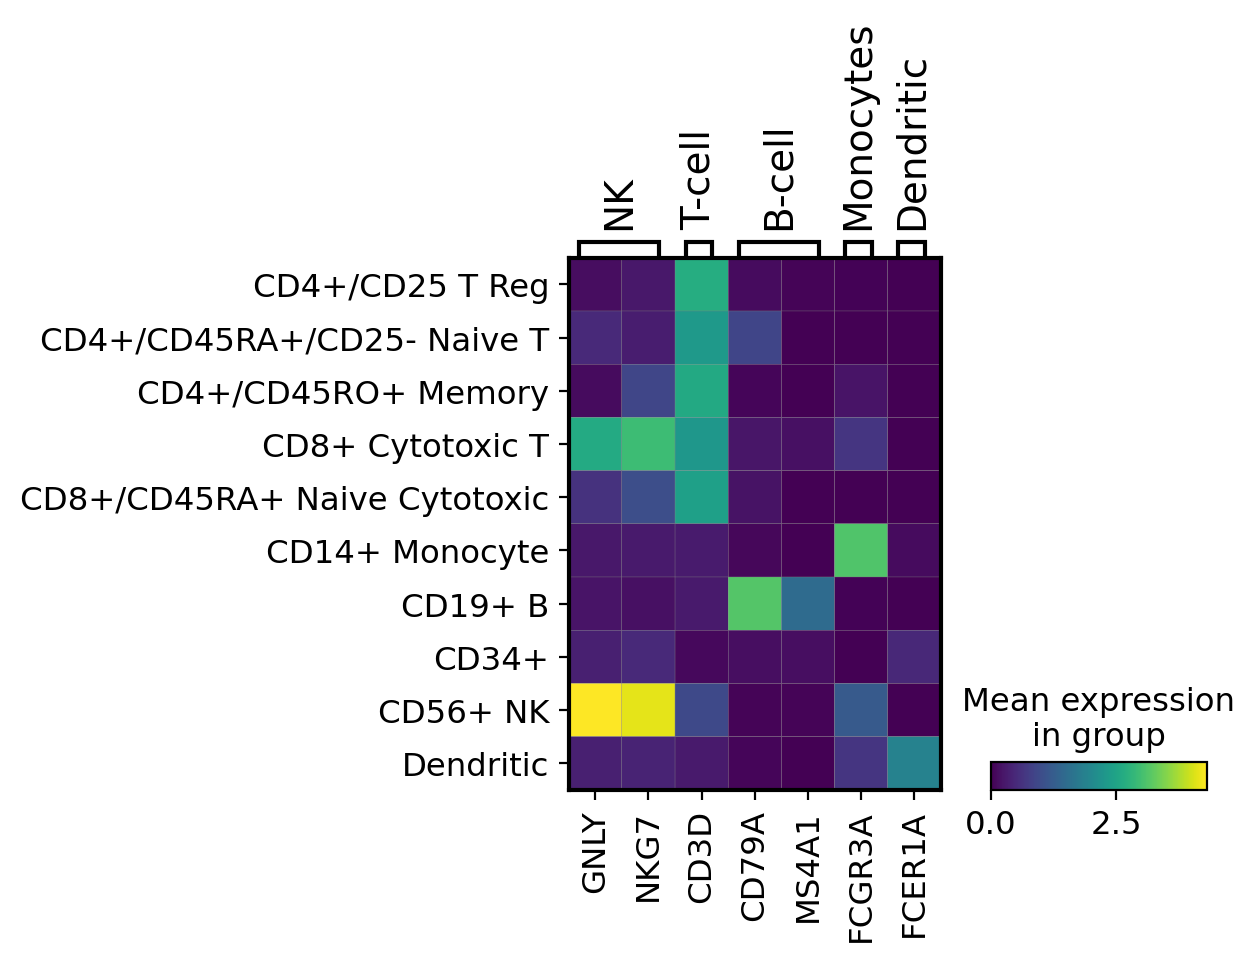

In [ ]:
gs = sc.pl.matrixplot(pbmc, marker_genes_dict, groupby='bulk_labels')

categories: CD4+/CD25 T Reg, CD4+/CD45RA+/CD25- Naive T, CD4+/CD45RO+ Memory, etc.
var_group_labels: NK, T-cell, B-cell, etc.


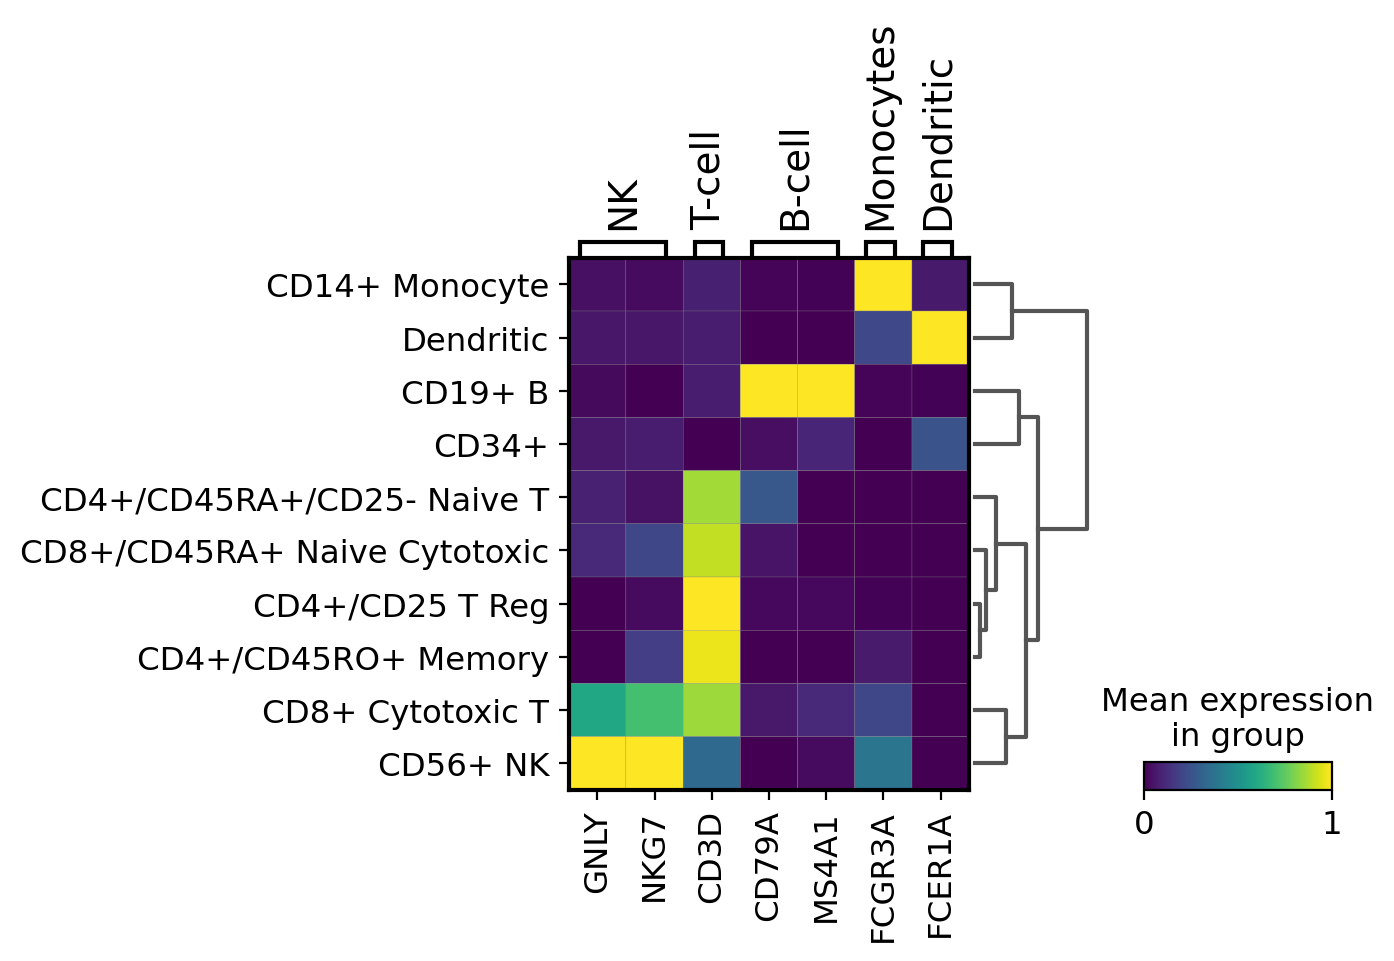

In [ ]:
gs = sc.pl.matrixplot(pbmc,
                      marker_genes_dict,
                      groupby='bulk_labels',
                      dendrogram=True,
                      standard_scale='var')

他の便利なオプションは、`sc.pp.scale`を使って遺伝子発現を正規化することです。
ここでは、この情報を`scale`レイヤーの下に保存します。
その後、プロットの最小値と最大値を調整し、カラーマップ`RdBu_r`を使用します。

In [ ]:
# scale and store results in layer
pbmc.layers['scaled'] = sc.pp.scale(pbmc, copy=True).X

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


/opt/conda/lib/python3.7/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


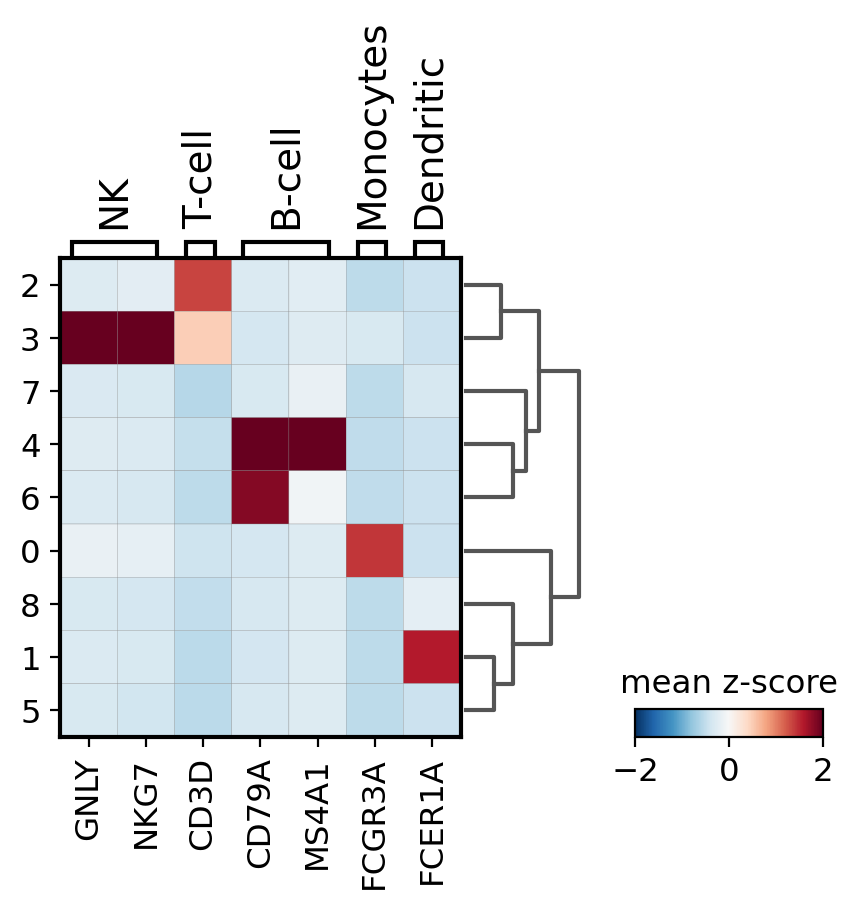

In [ ]:
sc.pl.matrixplot(pbmc, marker_genes_dict, 'clusters', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r')

## Combining plots in subplots

`axis`は、以下の例のように複数の出力を組み合わせるためにプロットに渡すことができます。


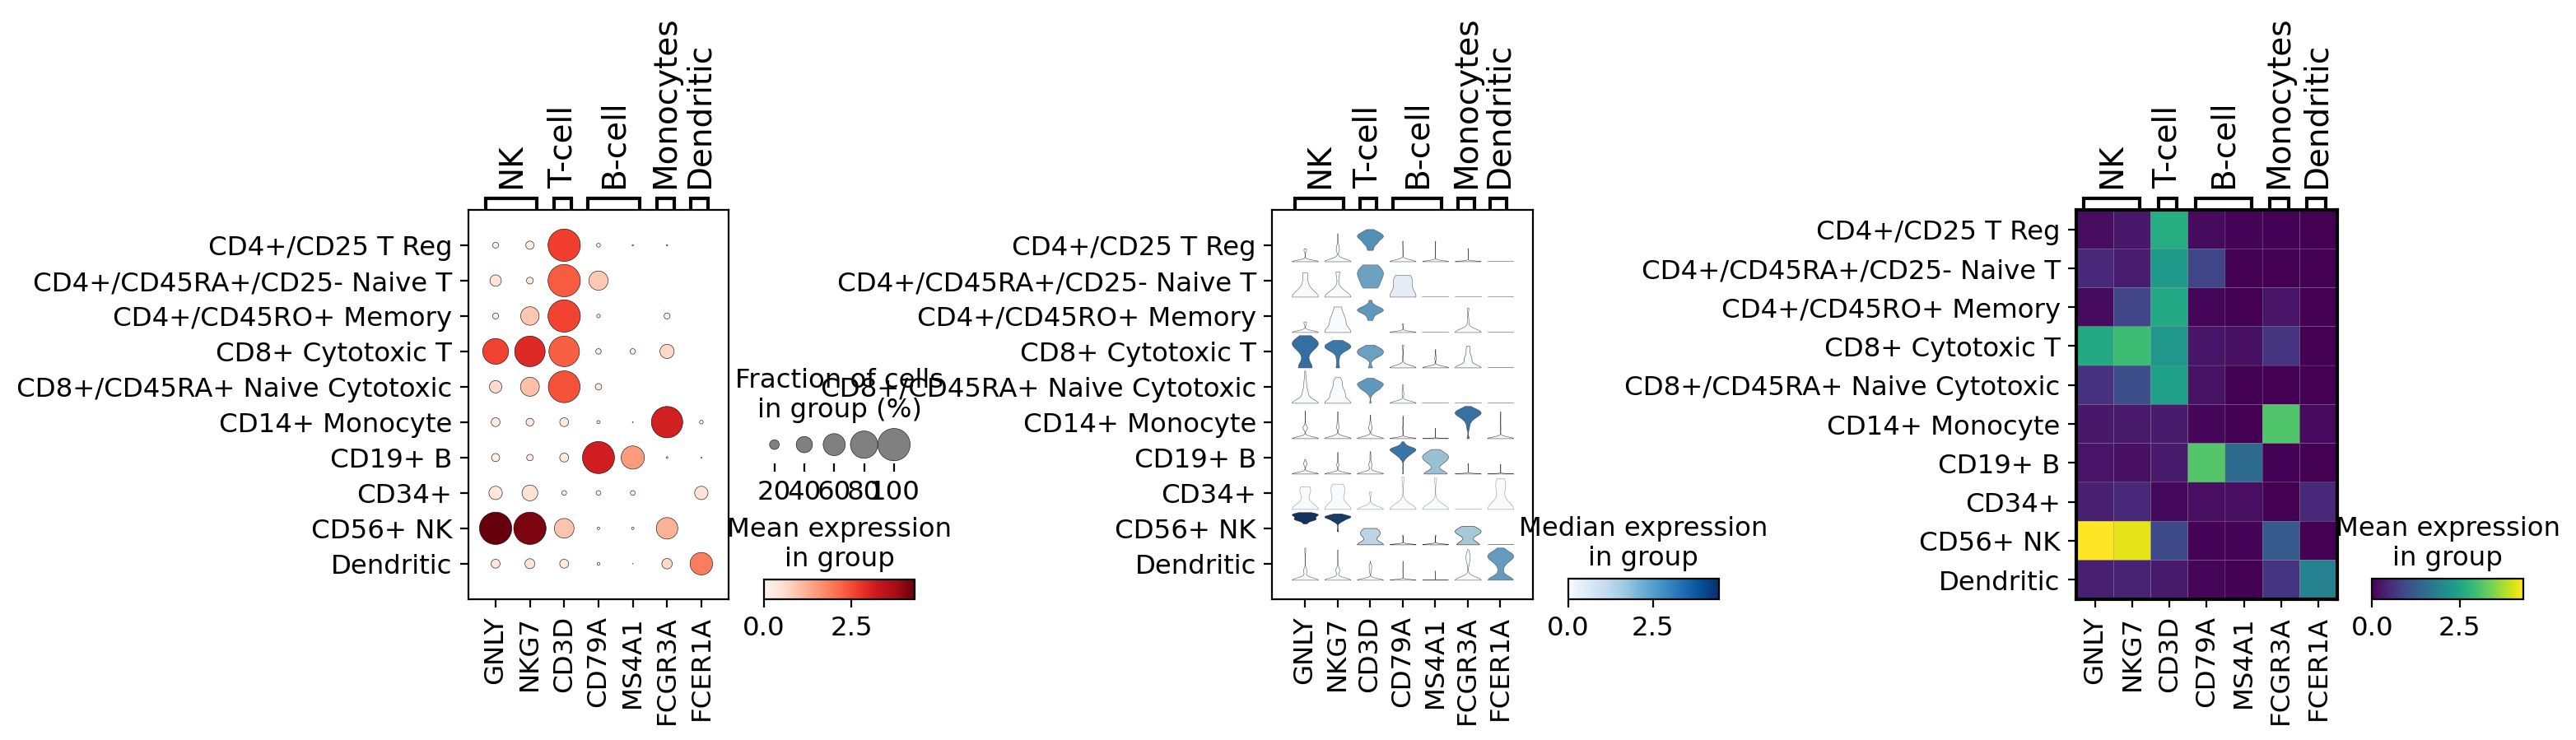

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.8})
ax1_dict = sc.pl.dotplot(pbmc, marker_genes_dict, groupby='bulk_labels', ax=ax1, show=False)
ax2_dict = sc.pl.stacked_violin(pbmc, marker_genes_dict, groupby='bulk_labels', ax=ax2, show=False)
ax3_dict = sc.pl.matrixplot(pbmc, marker_genes_dict, groupby='bulk_labels', ax=ax3, show=False, cmap='viridis')

## Heatmaps

ヒートマップは、クラスタの平均発現量を表現するのではなく、各行（`swap_axes=True`の場合は列）に各細胞を表示します。
`groupby`情報を追加することができ、`sc.pl.umap`や他の次元削減と同じカラーコードを使用して表示されます。

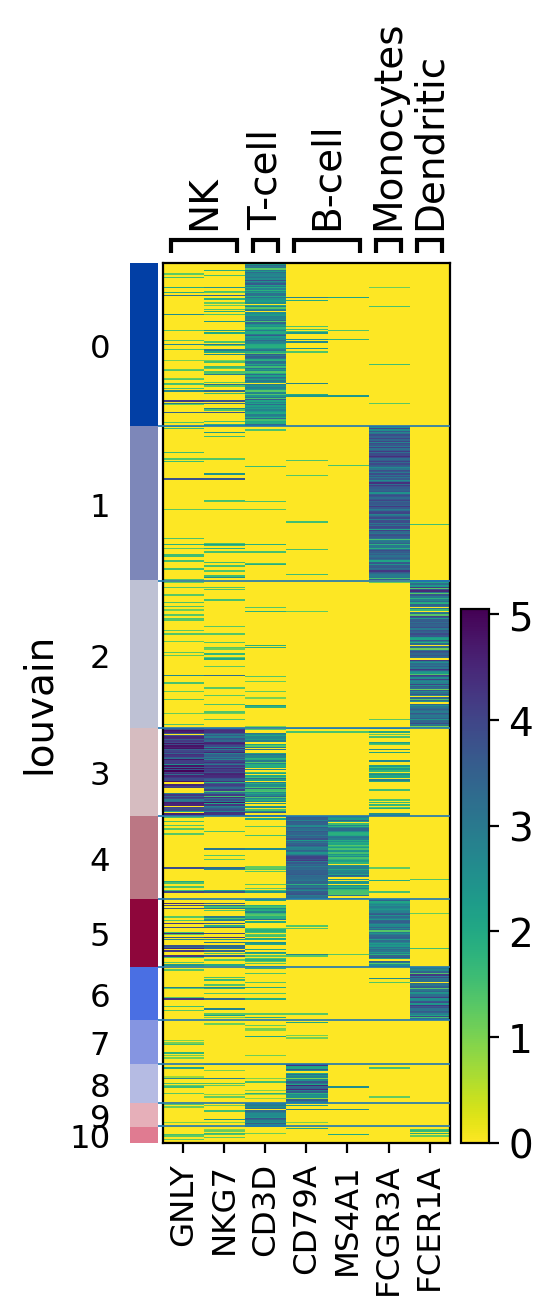

In [ ]:
ax = sc.pl.heatmap(pbmc,marker_genes_dict, groupby='louvain')

ヒートマップはスケーリングされたデータも表示することができます。

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


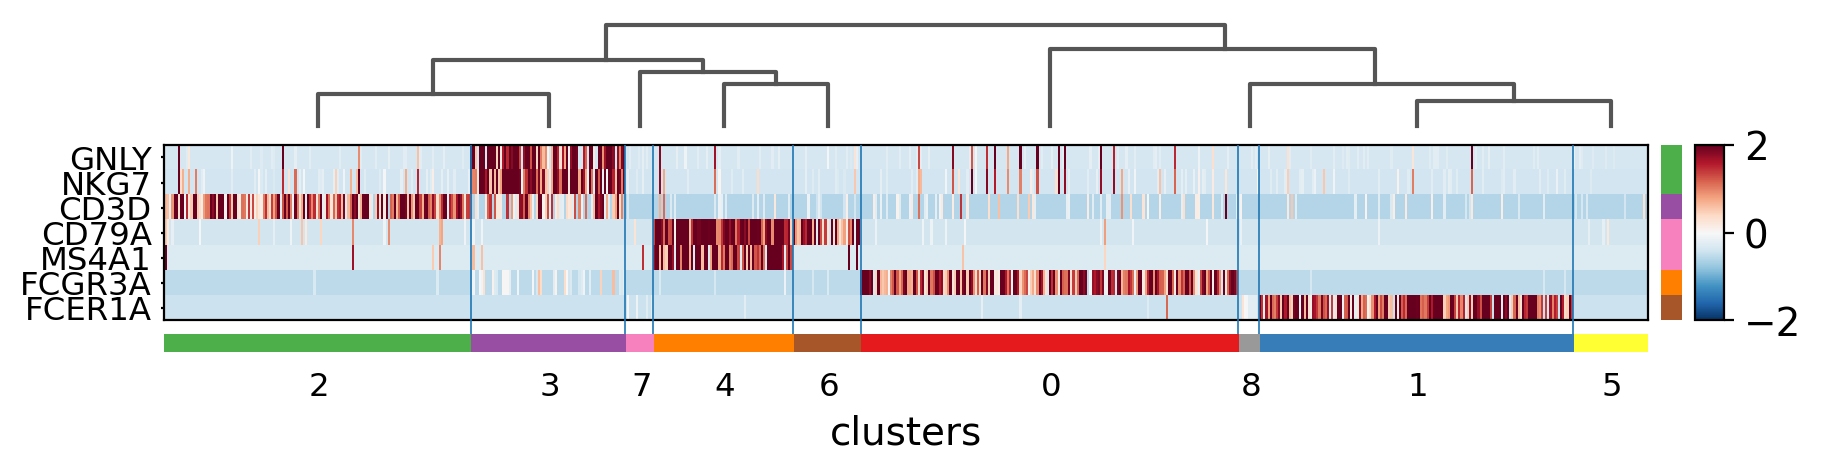

In [ ]:
ax = sc.pl.heatmap(pbmc, 
                   marker_genes_dict,
                   groupby='clusters', 
                   layer='scaled', 
                   vmin=-2, vmax=2,
                   cmap='RdBu_r',
                   dendrogram=True,
                   swap_axes=True)

## Tracksplot

トラックプロットはヒートマップと同じ情報を表示しますが、カラースケールの代わりに遺伝子発現を高さで表現しています。

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


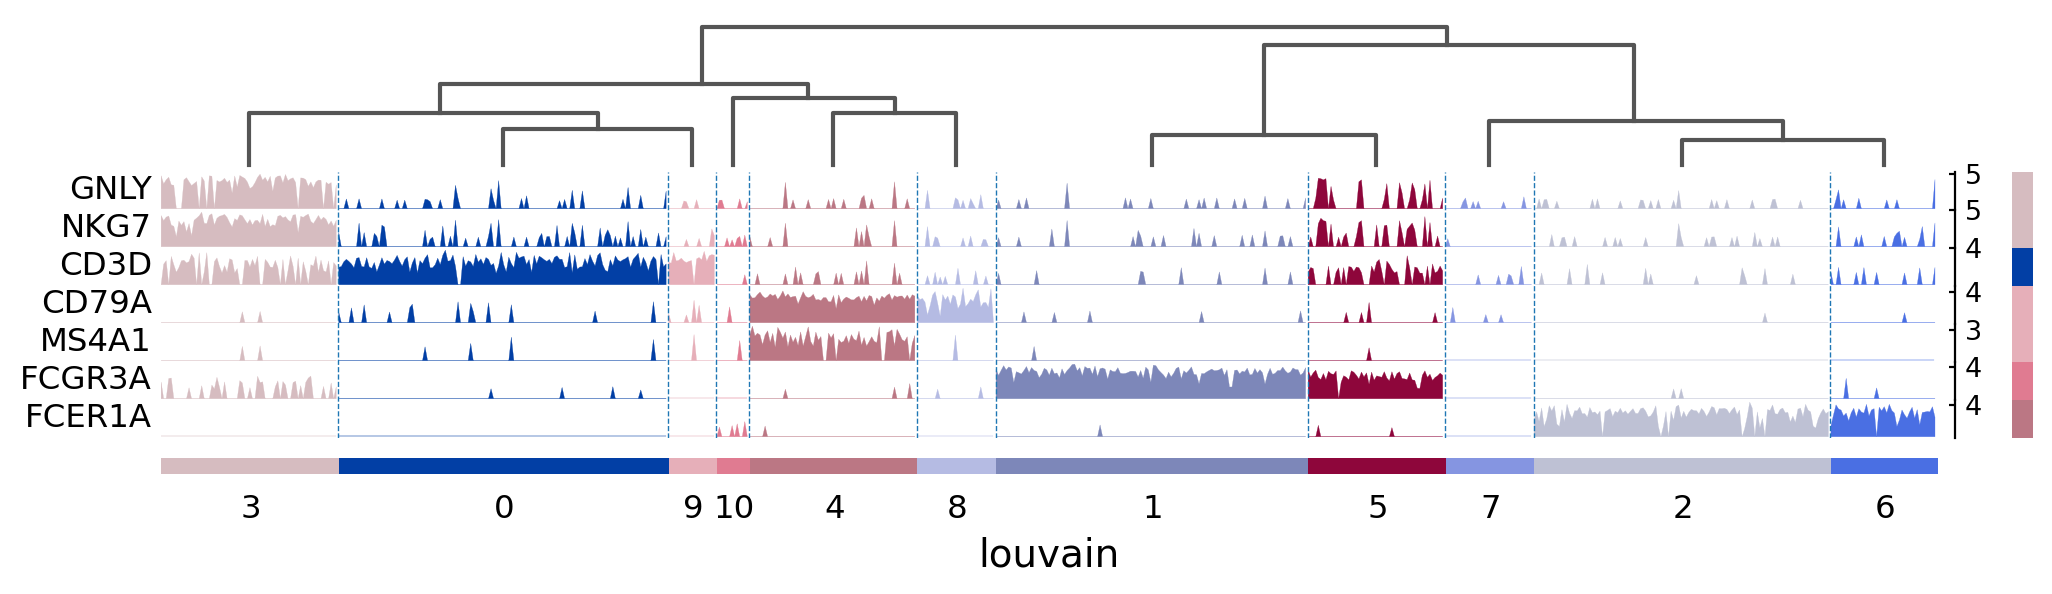

In [ ]:
ax = sc.pl.tracksplot(pbmc,marker_genes_dict, groupby='louvain', dendrogram=True)

## Visualization of marker genes

- 従来のように既知の遺伝子マーカーによってクラスターを特徴付けるのではなく、クラスター内の発現変動遺伝子を利用することもできます。
- 発現変動遺伝子を特定するために `sc.tl.rankg_genes_groups` を実行します。この関数は各クラスタについて、クラスタ内の各遺伝子の分布を他の全細胞の分布と比較します。
- ここでは、10xで与えられた元の細胞ラベルを用いて、これらの細胞タイプのマーカー遺伝子を同定します。

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# added `n_genes` to store information in all genes. This is needed if we want to plot log fold changes or pvalues
sc.tl.rank_genes_groups(pbmc, groupby='clusters', n_genes=pbmc.shape[1], method='wilcoxon')

### Visualize marker genes using dotplot

ドットプロットの可視化は、発現変動遺伝子の概要を得るのに便利です。出力図をコンパクトにするために、トップ4遺伝子のみを表示するために`n_genes=4`を使用します。

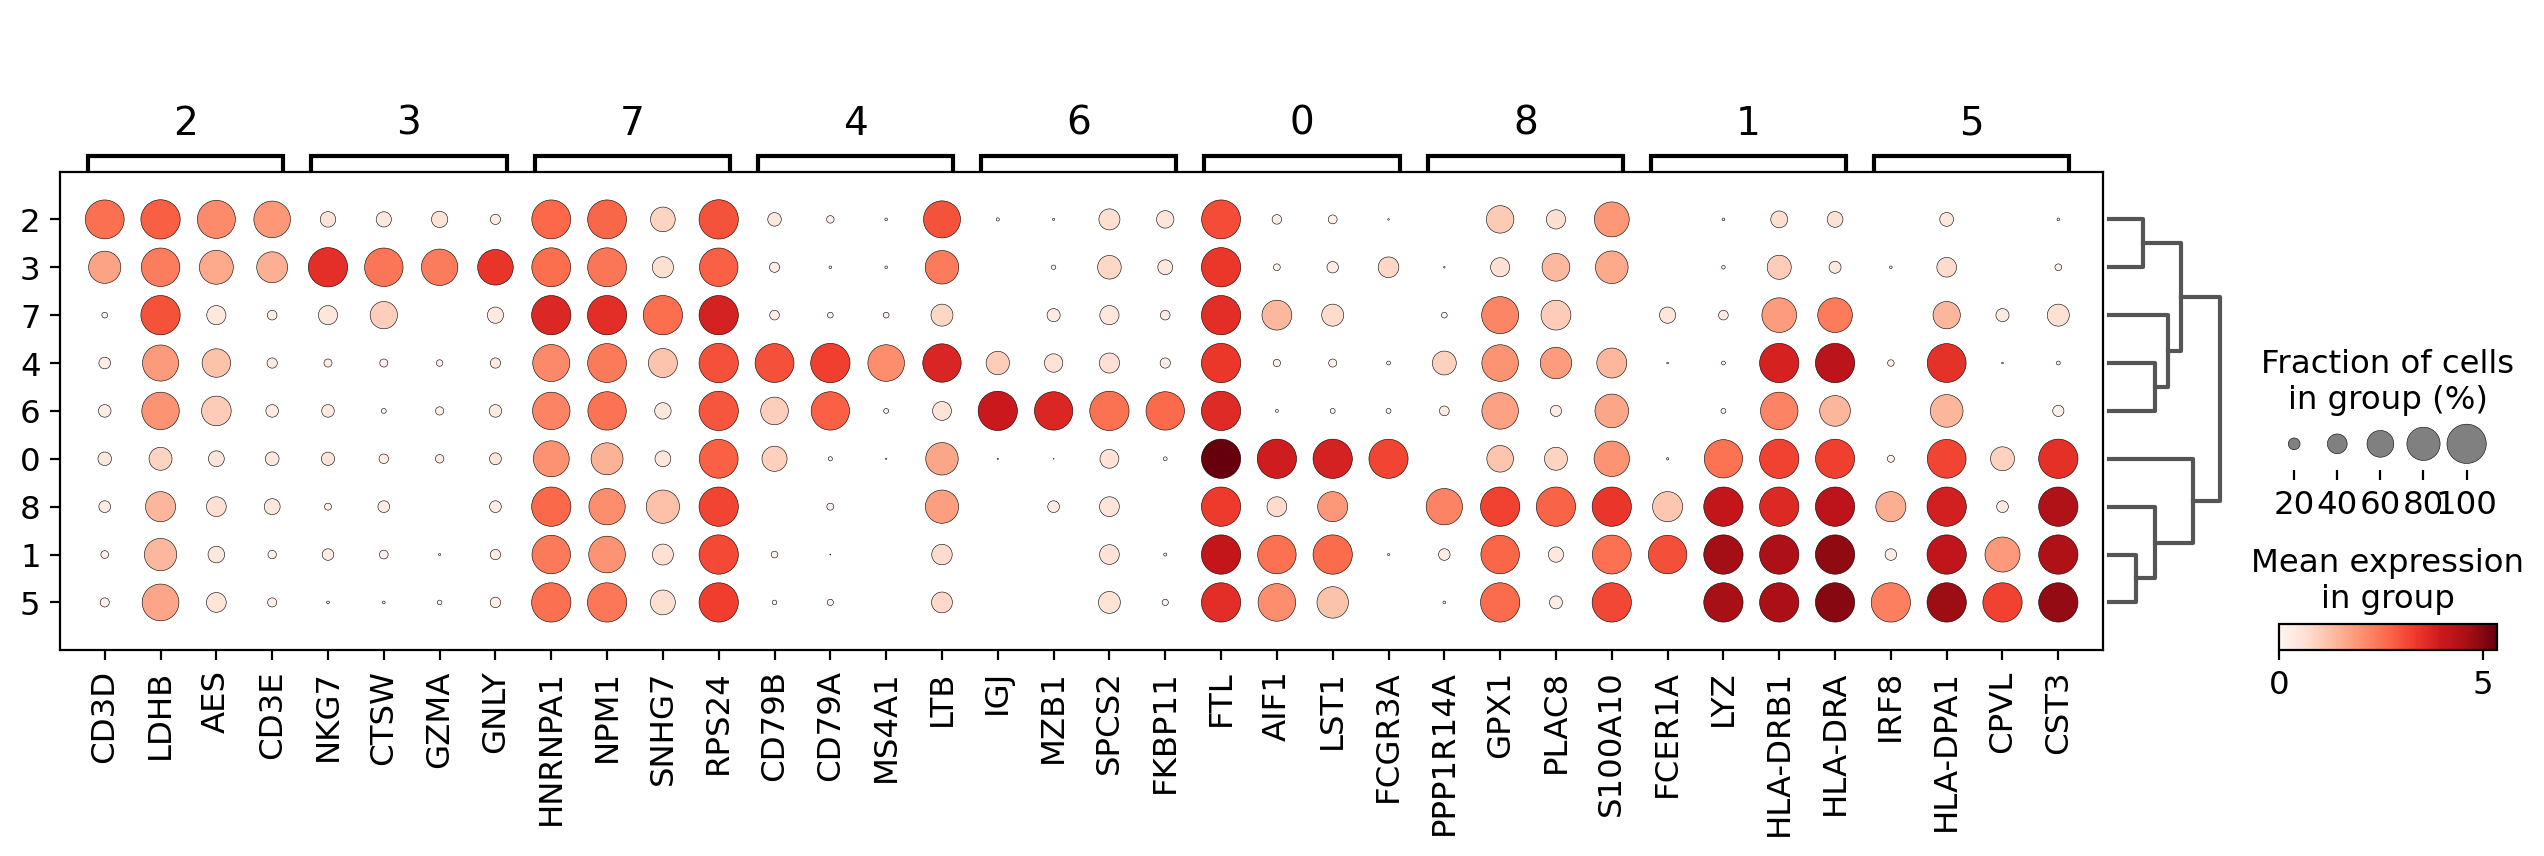

In [ ]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=4)

遺伝子発現量の代わりにlog foldchangeをプロットすることもできます。
ここでは他のクラスタに対して  log fold change >= 3 となる遺伝子に注目します。

この場合、`values_to_plot='logfoldchanges'`と `min_logfoldchange=3` を設定します。

logfold changeは発散スケールなので、プロットするminとmaxを調整し、発散カラーマップを使用します。次のプロットでは、T細胞の集団を区別するのが難しいことに注目してください。

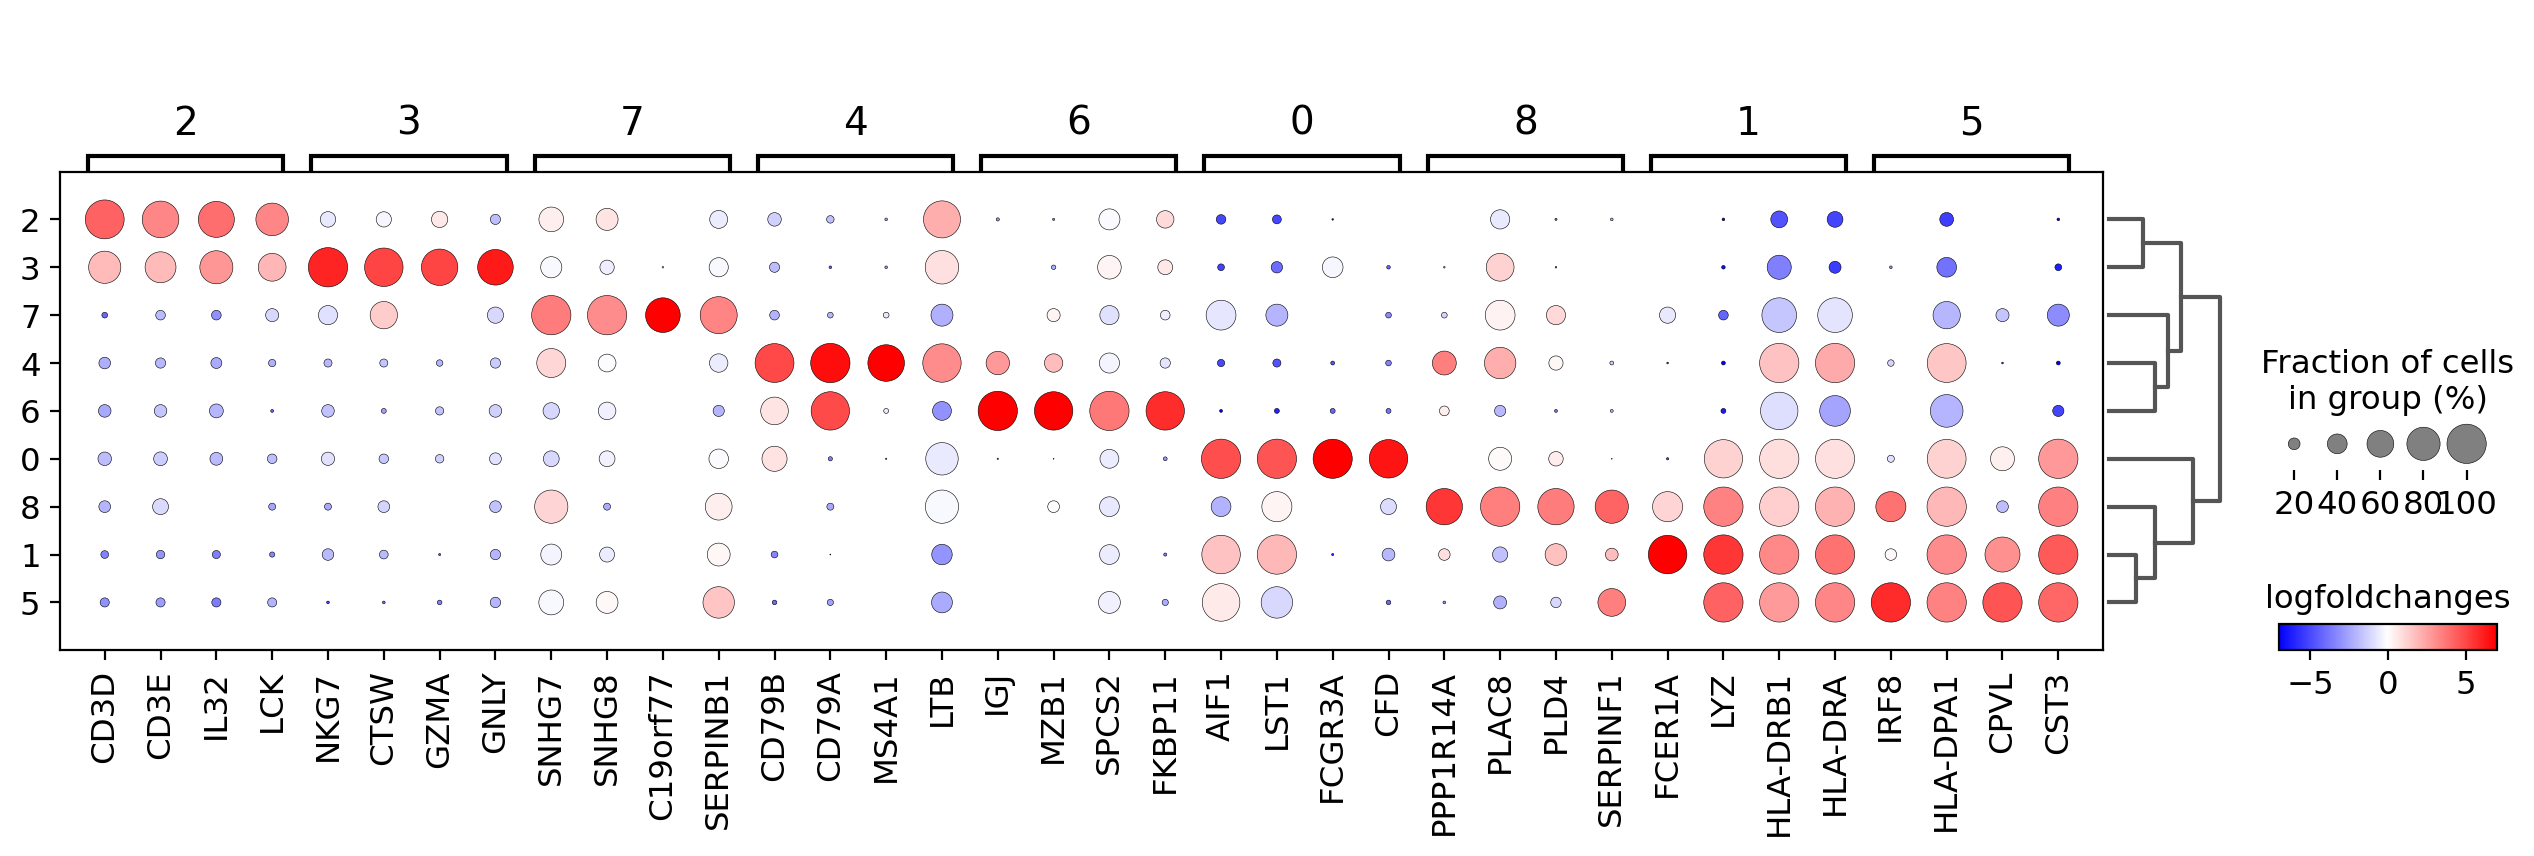

In [ ]:
sc.pl.rank_genes_groups_dotplot(pbmc,
                                n_genes=4, 
                                values_to_plot='logfoldchanges',
                                min_logfoldchange=3, 
                                vmax=7, vmin=-7,
                                cmap='bwr')

### Focusing on particular groups

次に、2つのグループのみに焦点を当てたドットプロットを使用します(groupsオプションはバイオリン、ヒートマップ、マトリックスプロットでも使用可能です)。ここでは、`min_logfoldchange=4, n_genes=30`によって最大30の遺伝子を表示します。

categories: 0, 1, 2, etc.
var_group_labels: 1, 5


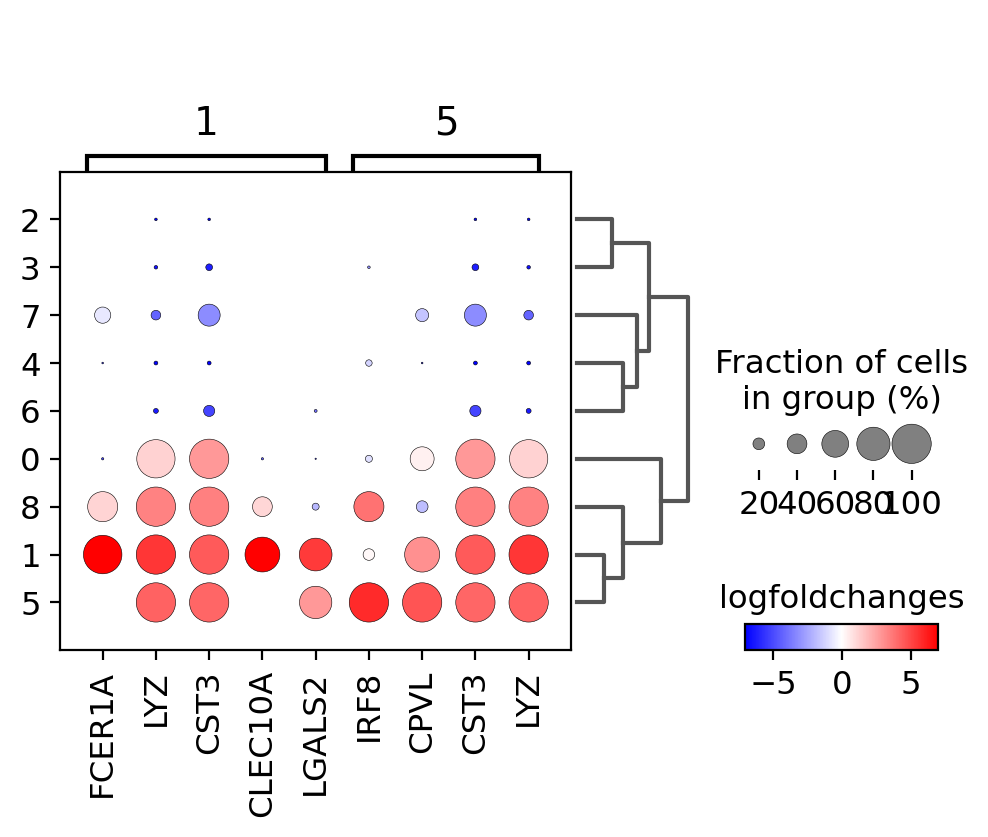

In [ ]:
sc.pl.rank_genes_groups_dotplot(pbmc, 
                                n_genes=30, 
                                values_to_plot='logfoldchanges',
                                min_logfoldchange=4, 
                                vmax=7, vmin=-7, 
                                cmap='bwr', 
                                groups=['1', '5'])

### Visualize marker genes using matrixplot

次のプロットでは、`scaled`レイヤーに保存されているスケールされた値を表示しています。

/opt/conda/lib/python3.7/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


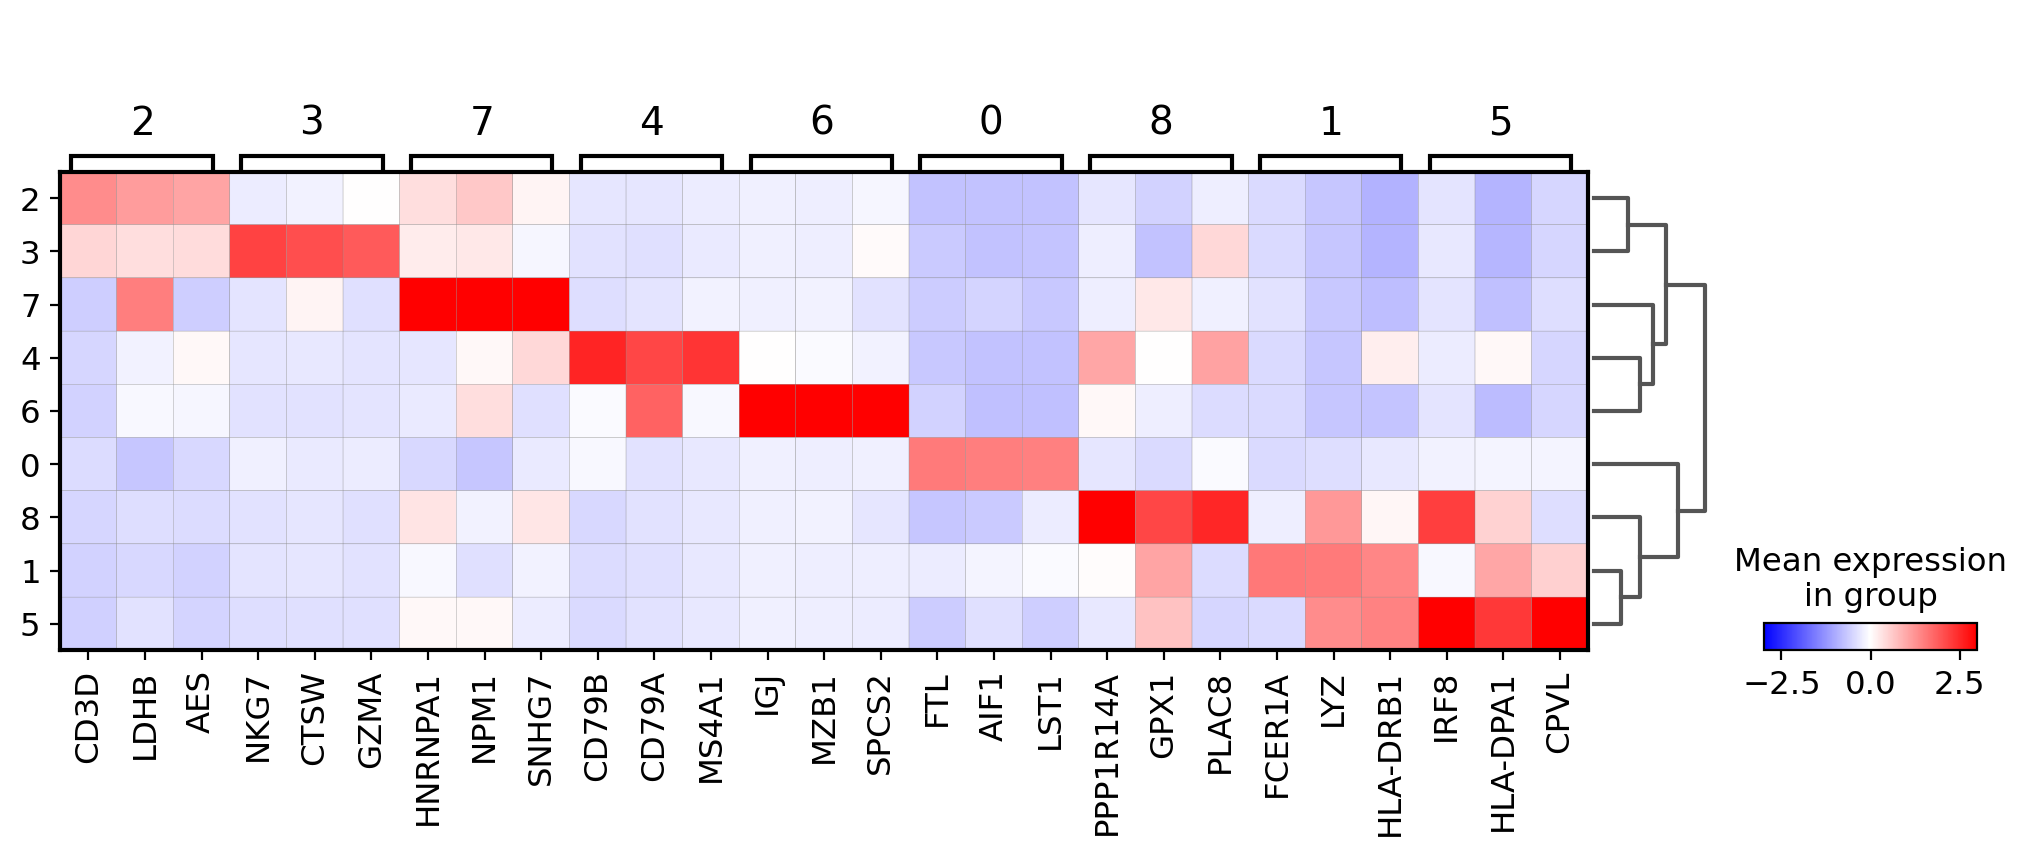

In [ ]:
sc.pl.rank_genes_groups_matrixplot(pbmc, n_genes=3, use_raw=False, vmin=-3, vmax=3, cmap='bwr', layer='scaled')

### Visualize marker genes using stacked violin plots



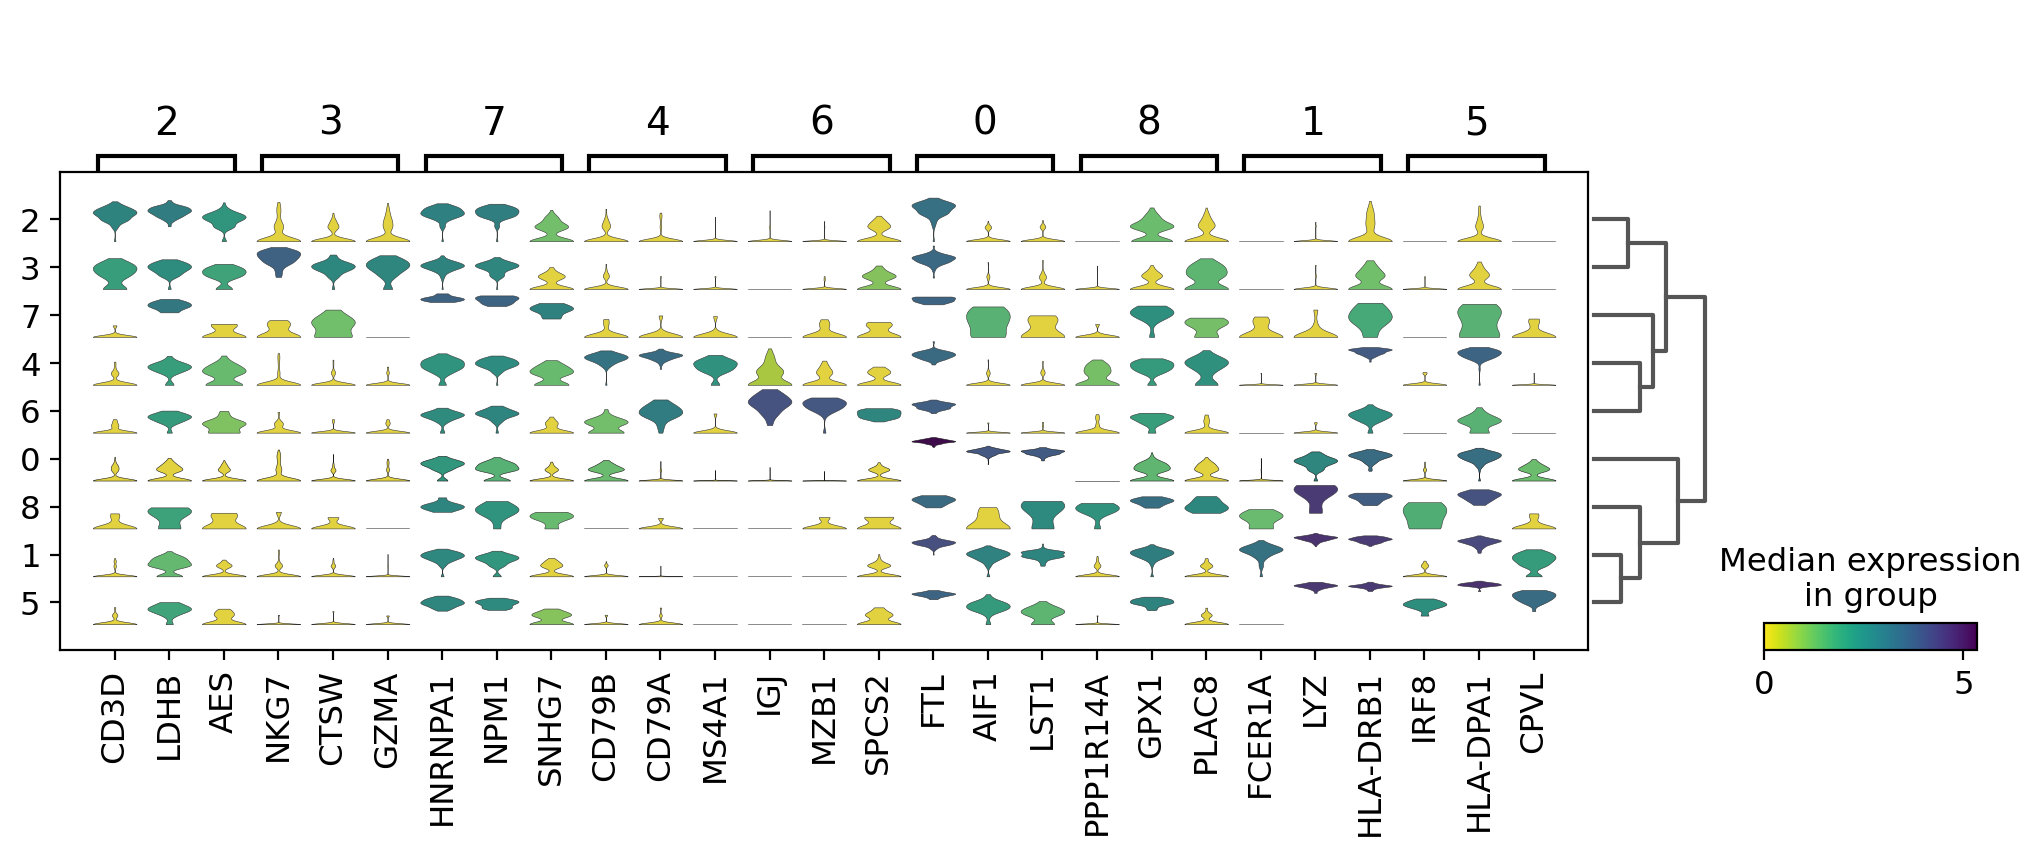

In [ ]:
sc.pl.rank_genes_groups_stacked_violin(pbmc, n_genes=3, cmap='viridis_r')

### Visualize marker genes using heatmap

クラスタごとに10個の遺伝子を表示し、遺伝子ラベルをオフにし、XY軸を入れ替えます。
軸が入れ替わると、クラスタの括弧が消え、代わりに色で表示されます。

{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='clusters'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

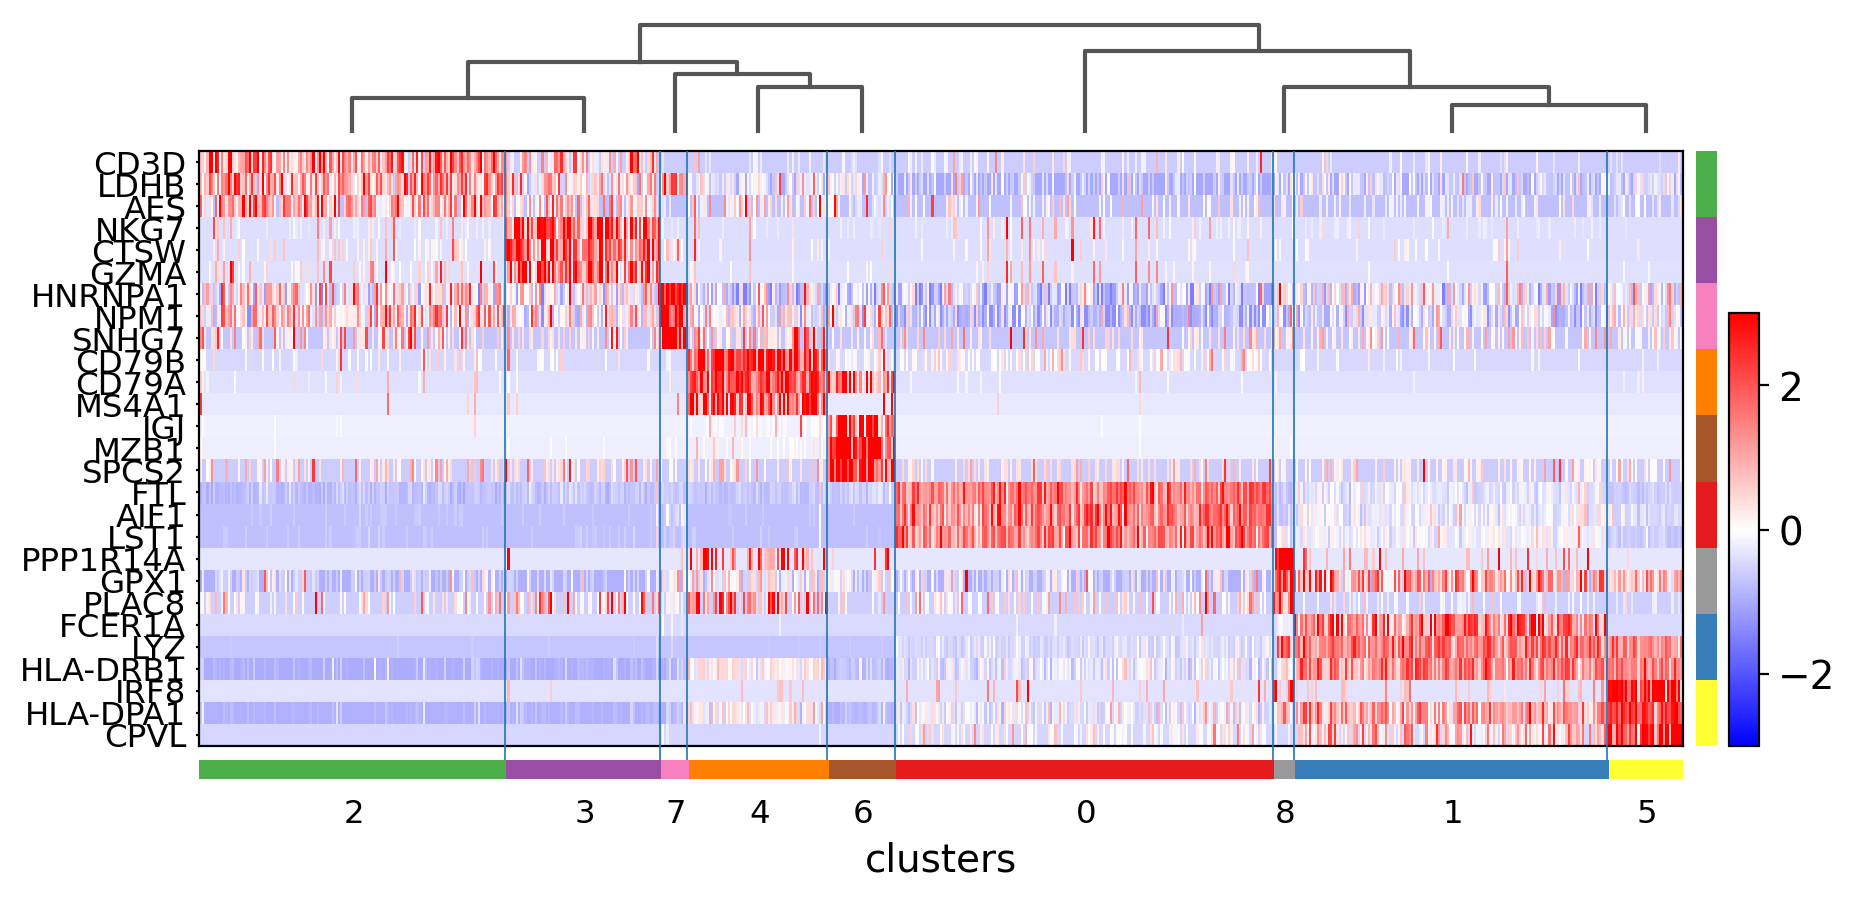

In [ ]:
sc.pl.rank_genes_groups_heatmap(pbmc, 
                                n_genes=3, 
                                use_raw=False,
                                swap_axes=True,
                                vmin=-3, vmax=3,
                                cmap='bwr', 
                                layer='scaled', 
                                figsize=(10,5),
                                show=False)

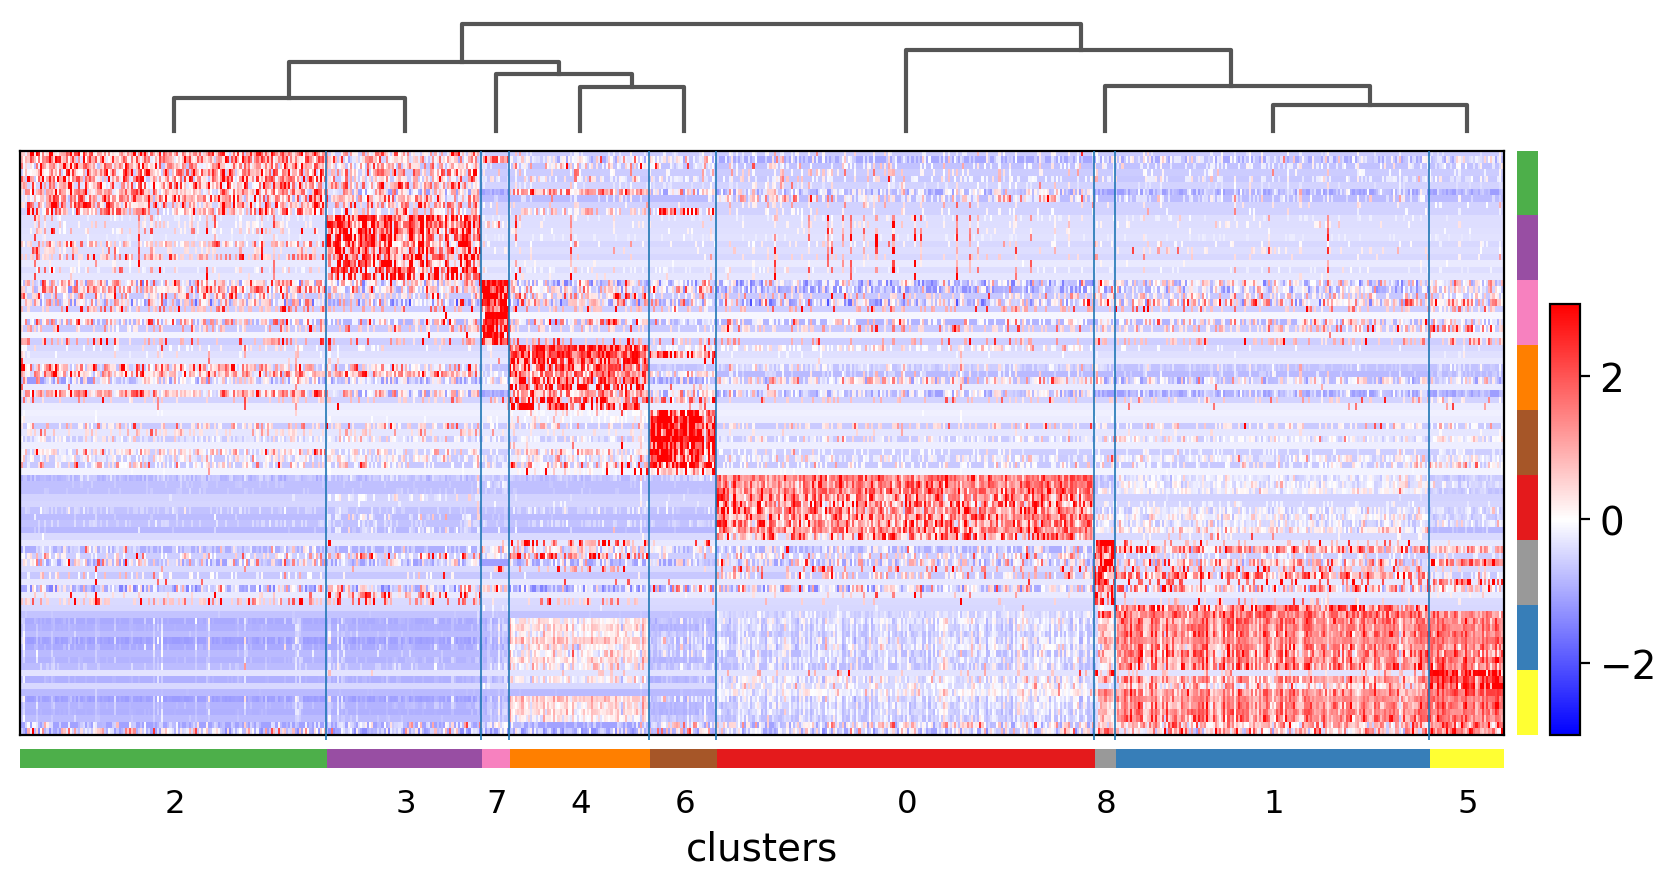

In [ ]:
sc.pl.rank_genes_groups_heatmap(pbmc,
                                n_genes=10, 
                                use_raw=False, 
                                swap_axes=True, 
                                show_gene_labels=False,
                                vmin=-3, vmax=3,
                                cmap='bwr')

### Visualize marker genes using tracksplot


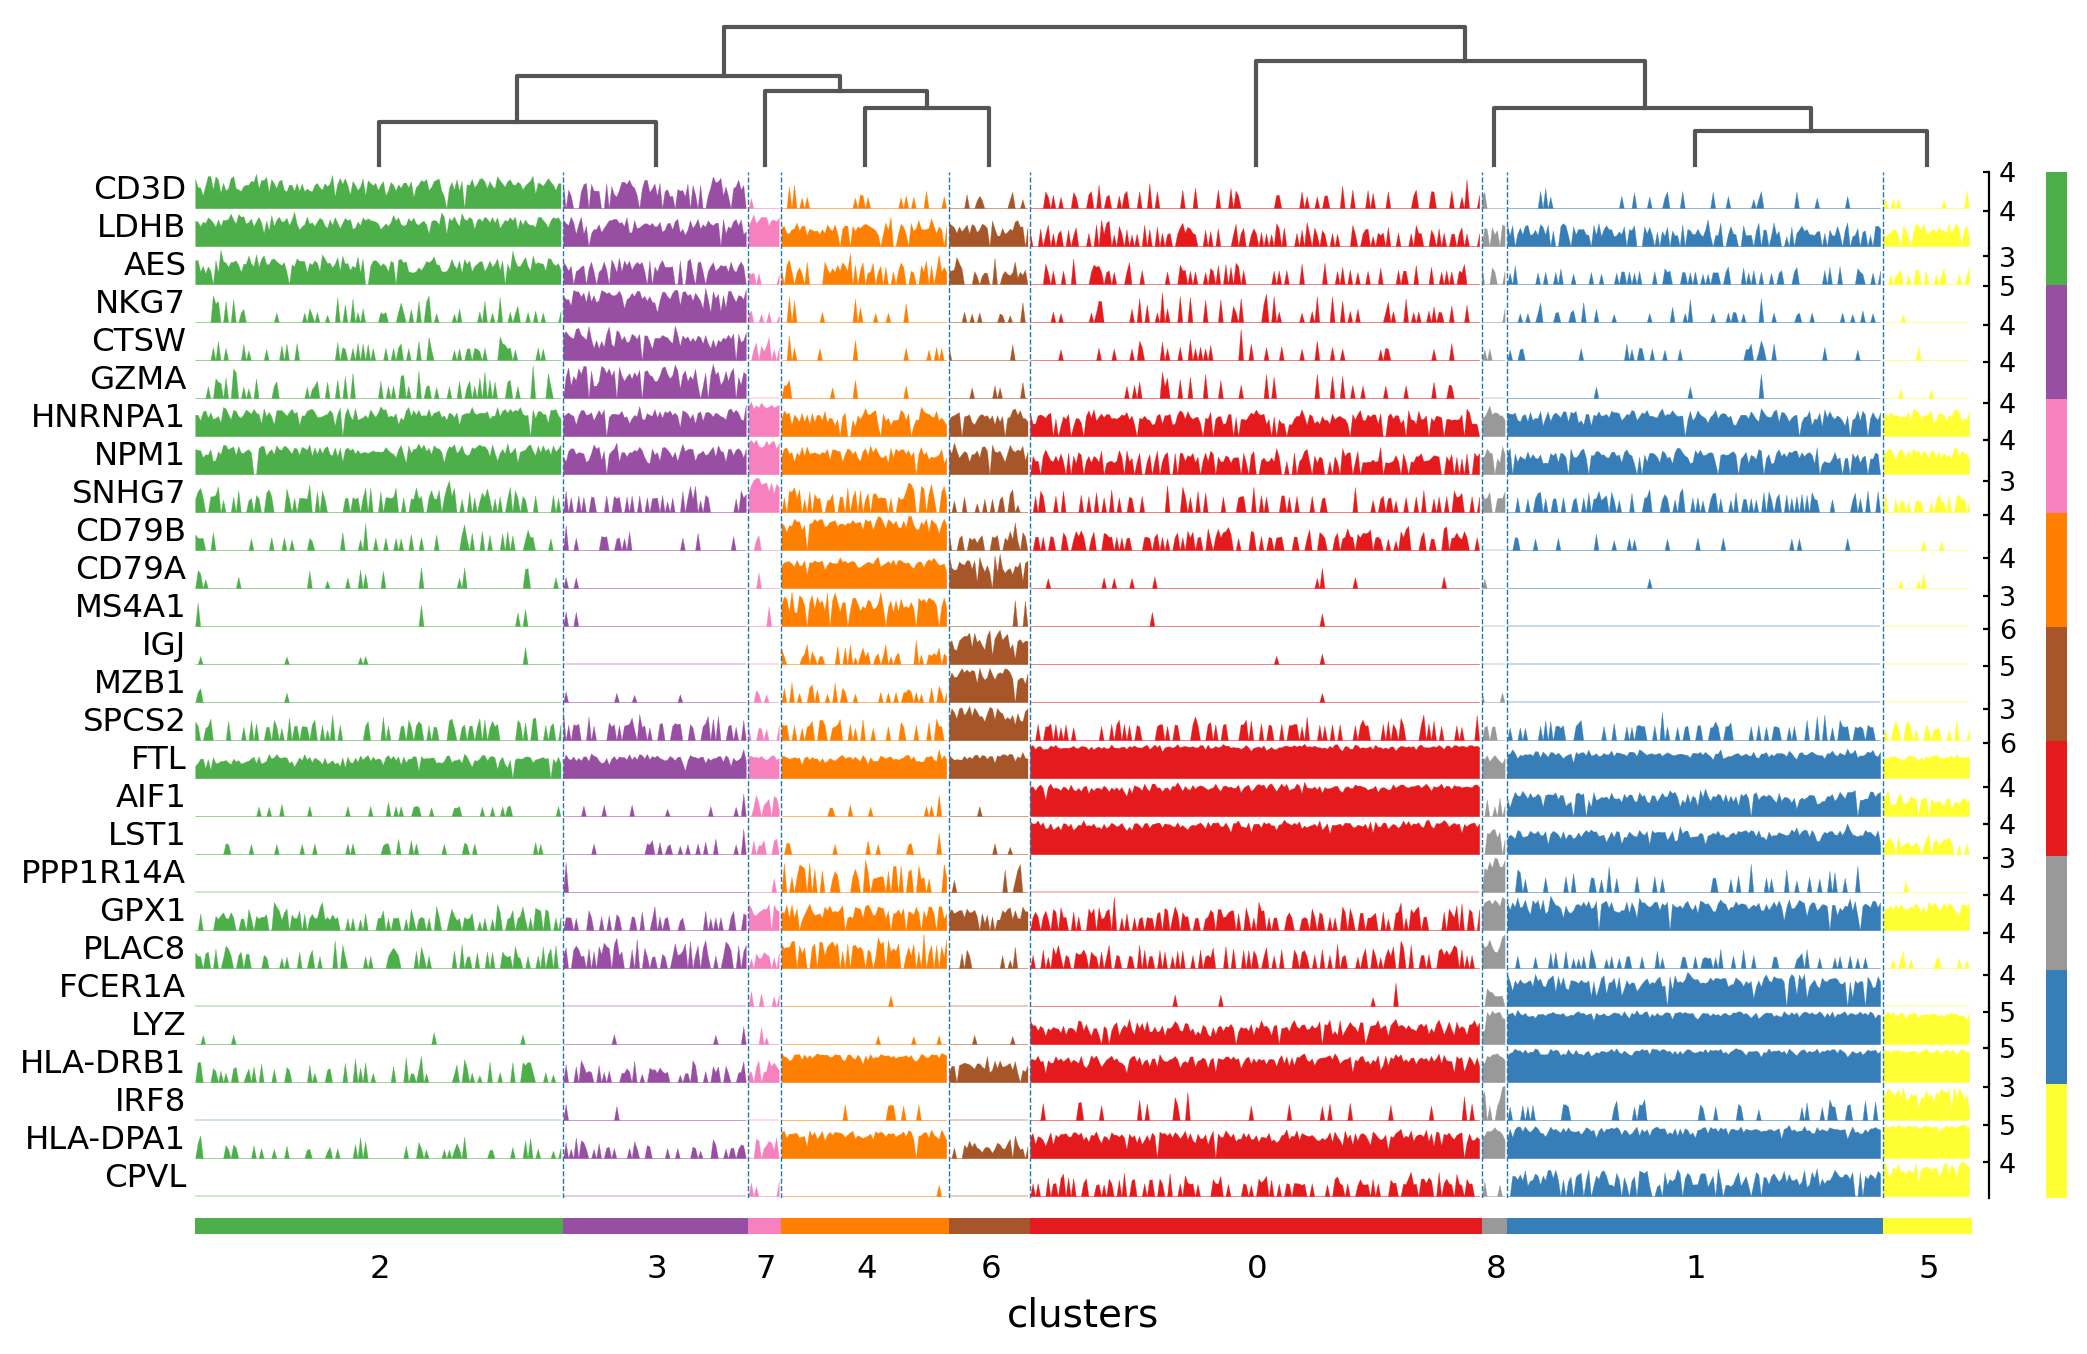

In [ ]:
sc.pl.rank_genes_groups_tracksplot(pbmc, n_genes=3)

## Comparison of marker genes using split violin plots

scanpyでは、すべてのグループに対してsplit violin plotsを用いて、マーカー遺伝子を一度に比較することが非常に簡単にできます。



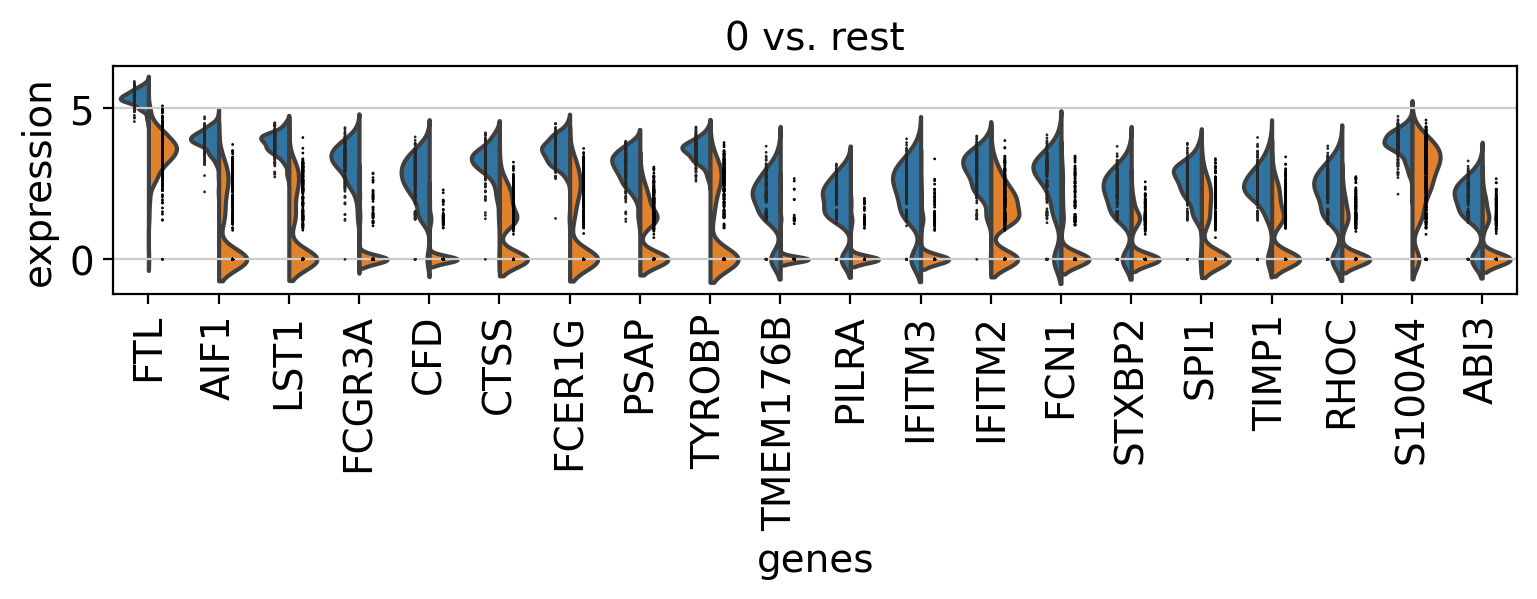

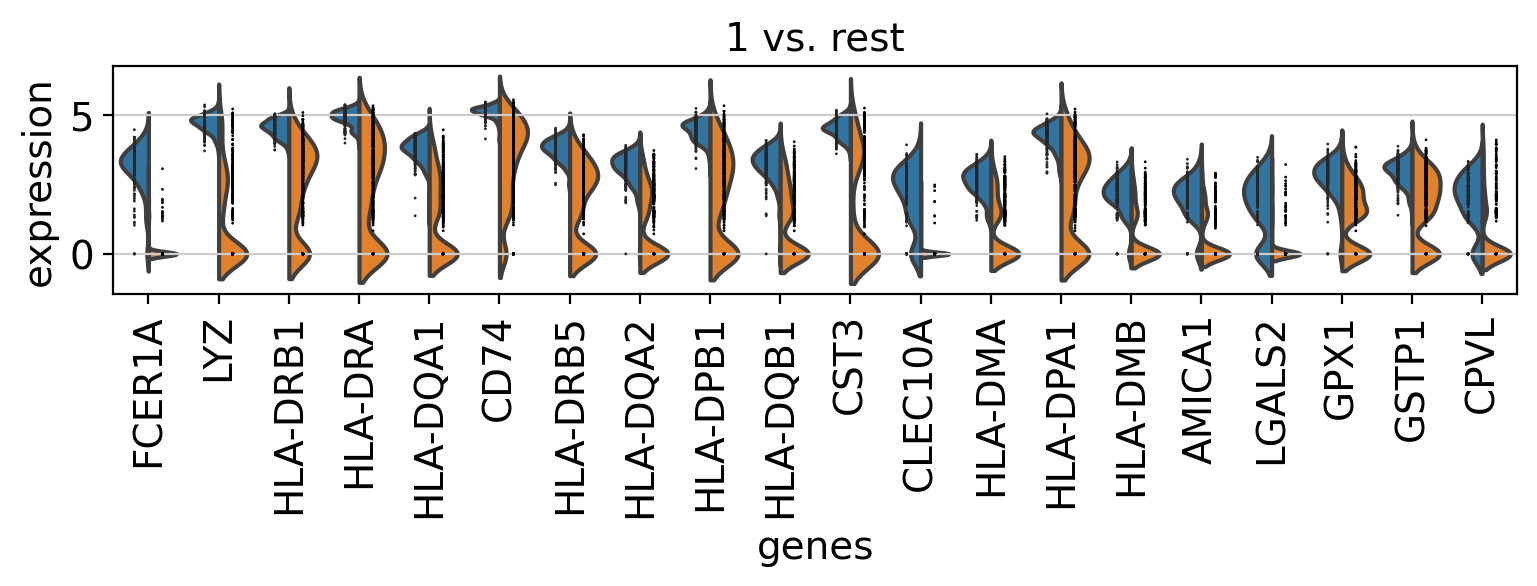

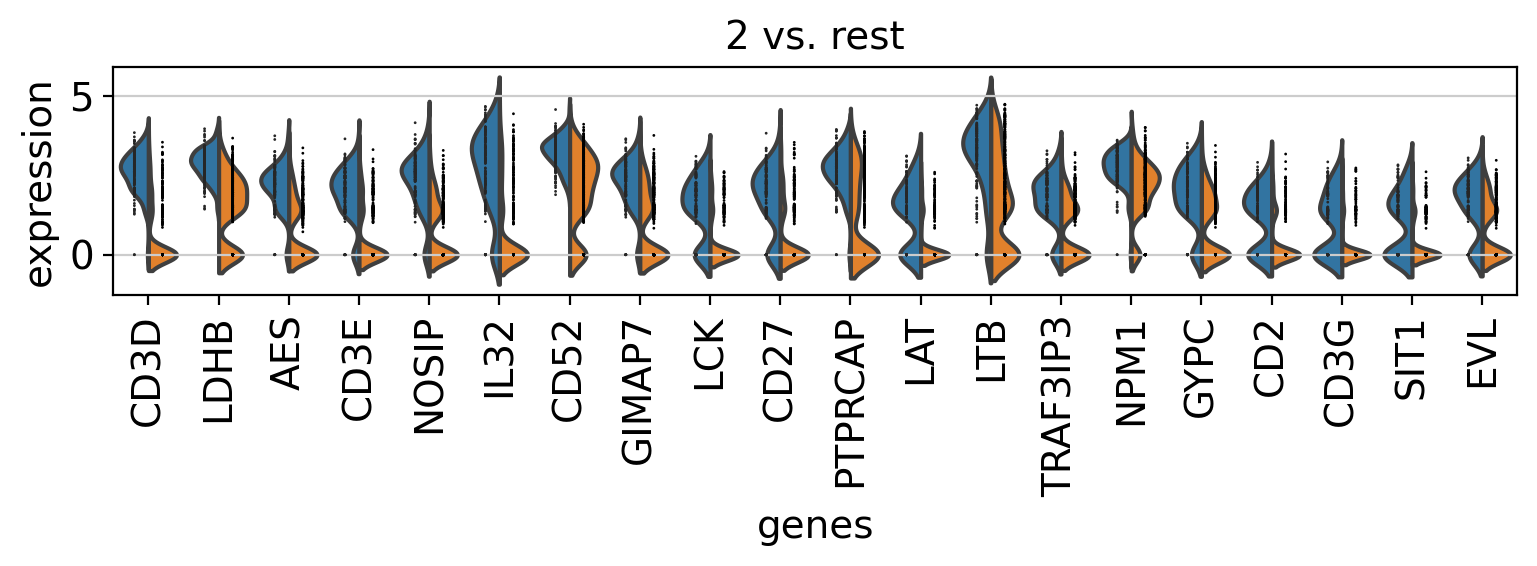

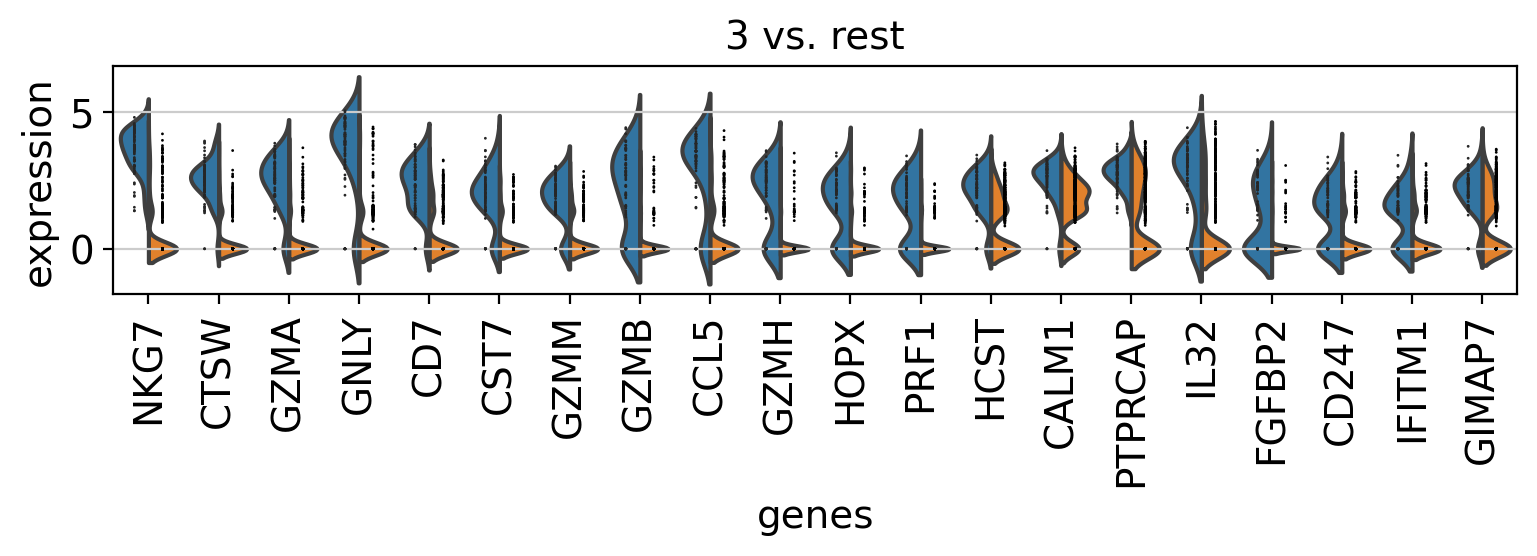

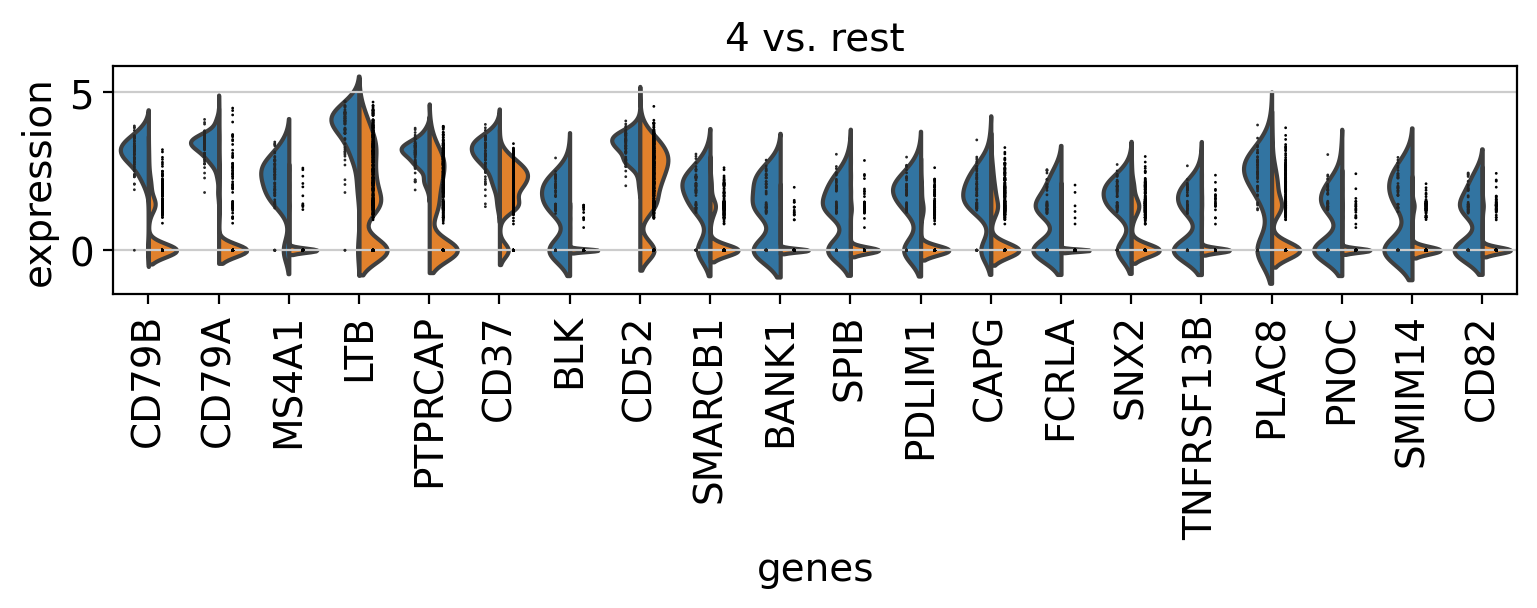

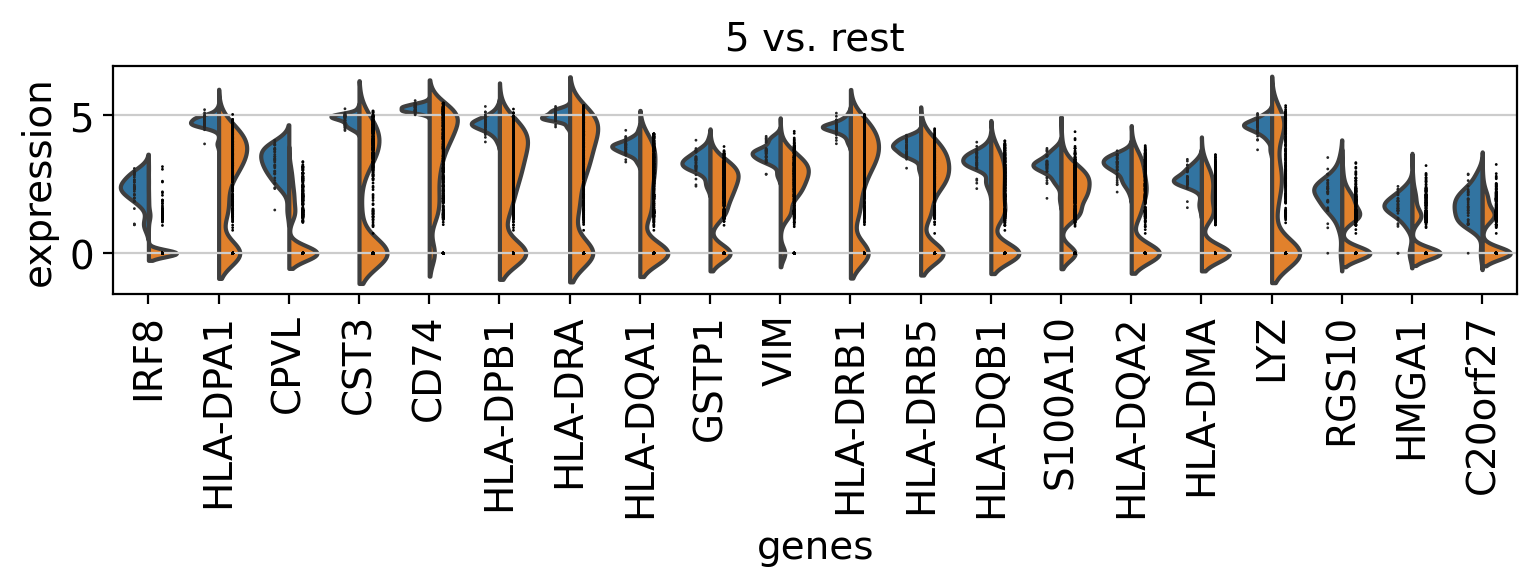

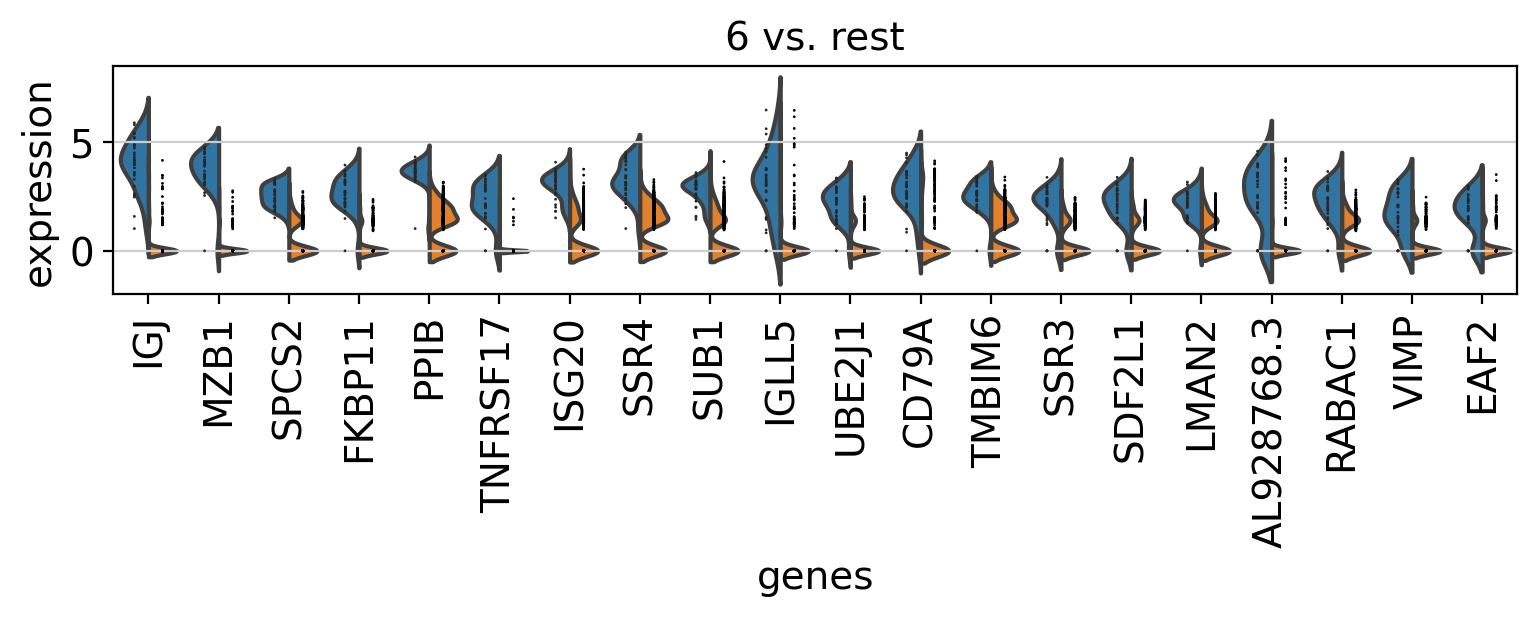

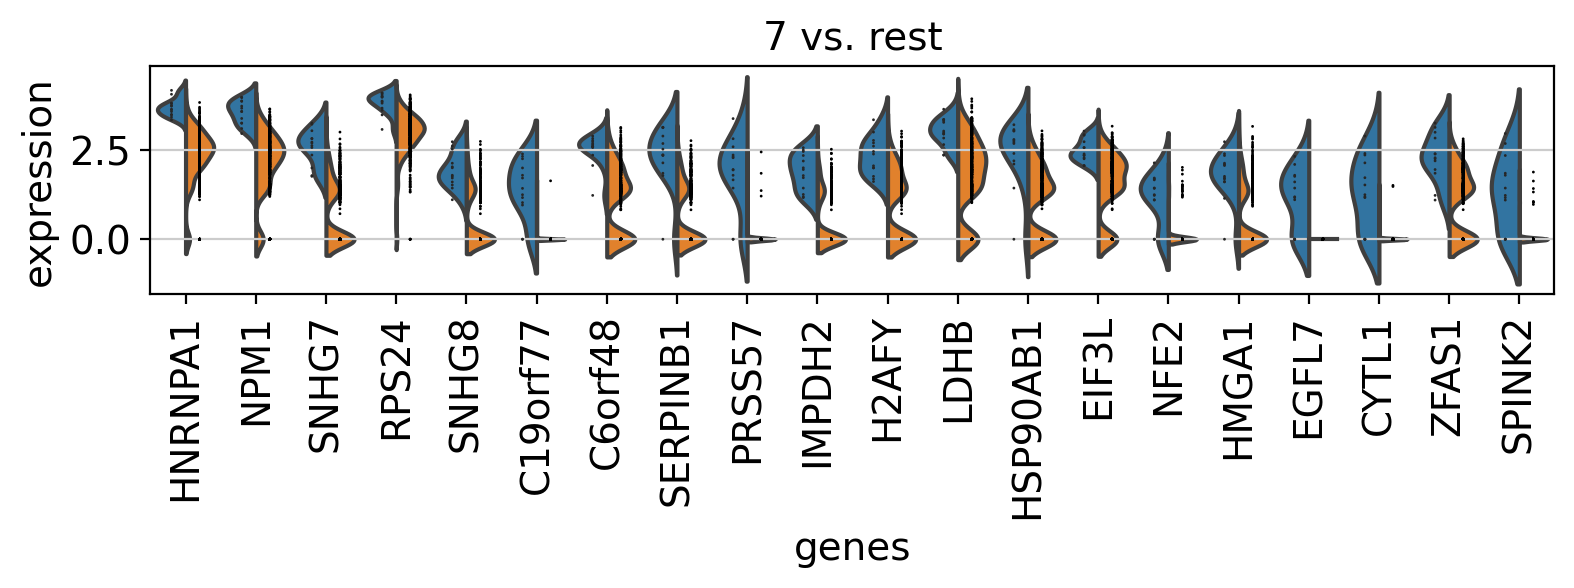

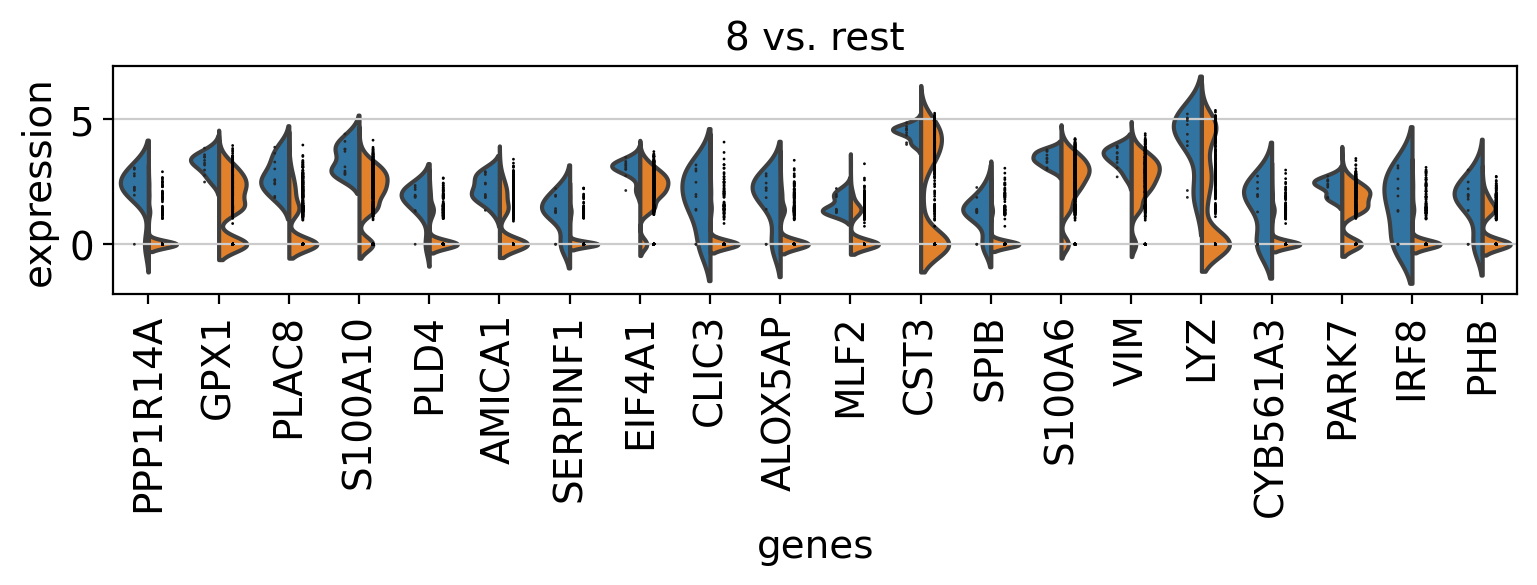

In [ ]:
rcParams['figure.figsize'] = 9,1.5
sc.pl.rank_genes_groups_violin(pbmc, n_genes=20, jitter=False)

## Dendrogram options

系統樹は以下のように独立してプロットすることもできます。

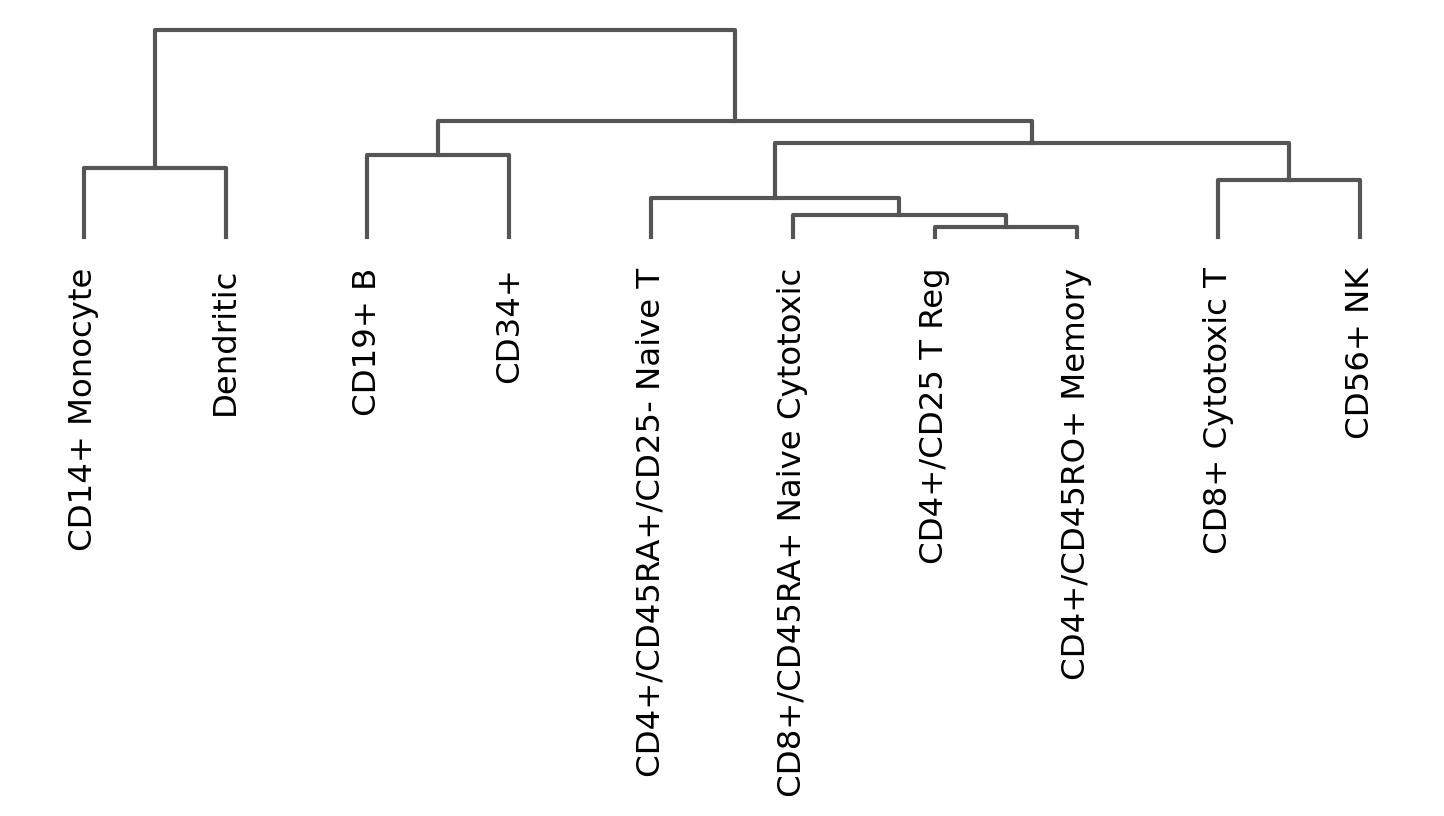

In [ ]:
# compute hierachical clustering based using PCAs (several options available to compute the distance matrix and linkage method are available).
sc.tl.dendrogram(pbmc, 'bulk_labels')
# plot
ax = sc.pl.dendrogram(pbmc, 'bulk_labels')

## Plot correlation

系統樹とともに、クラスタの相関係数（デフォルトでは'pearson'）をプロットすることができます。

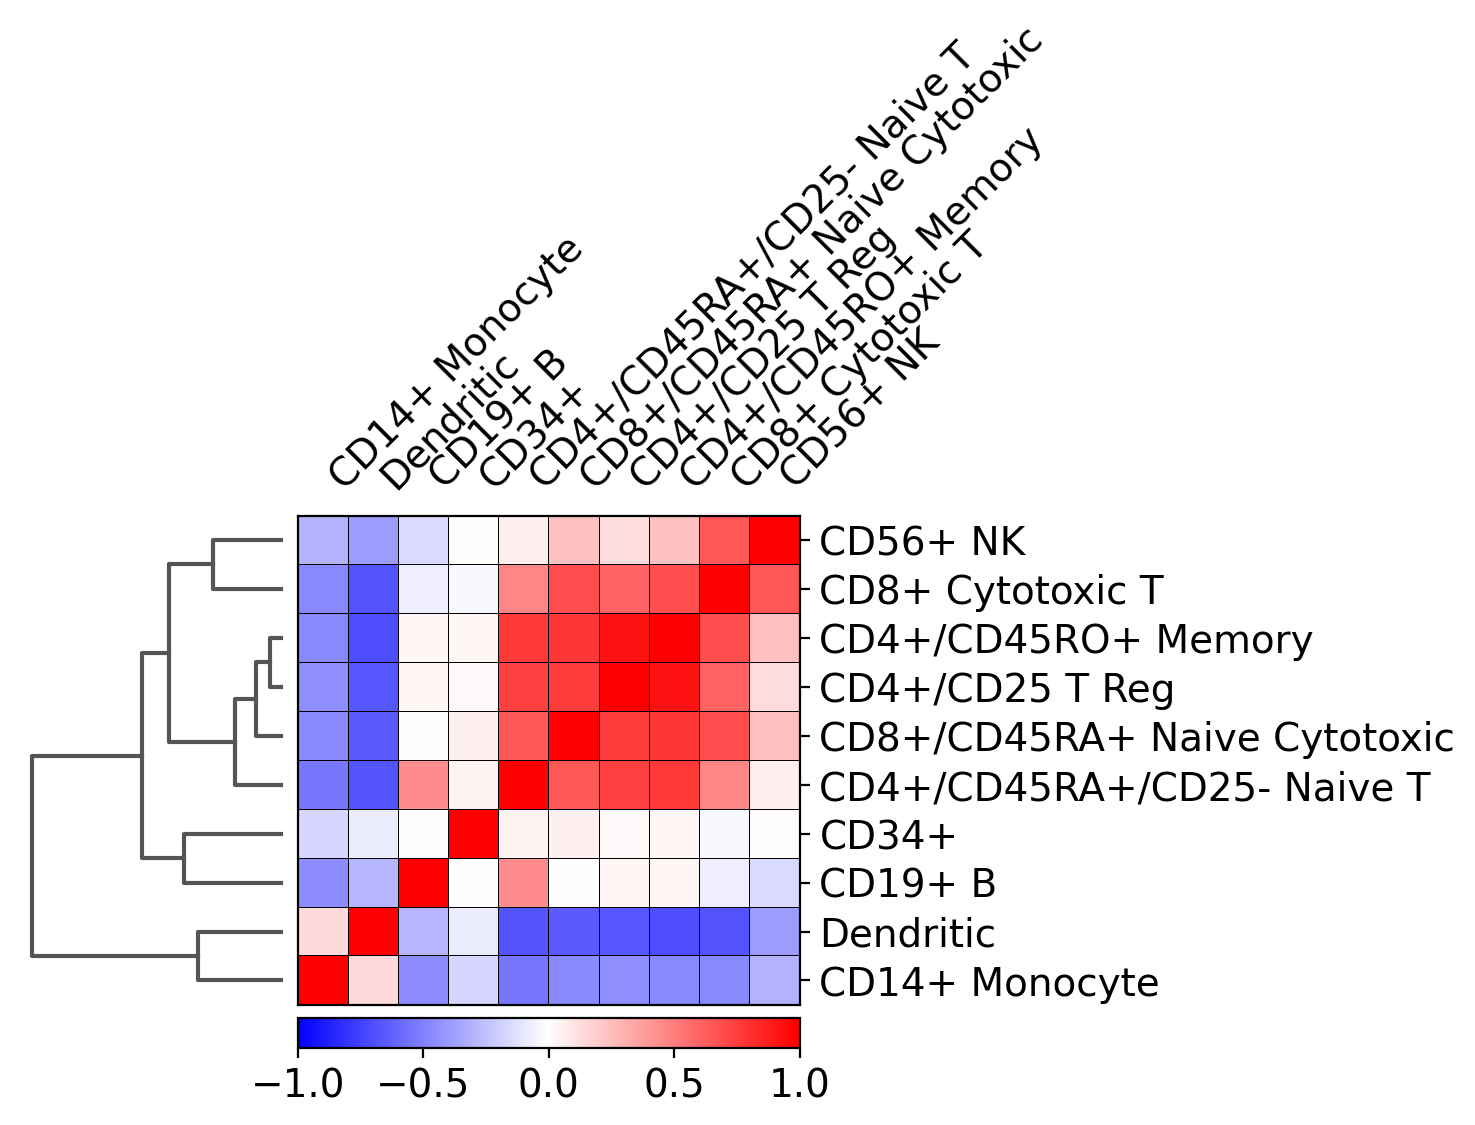

In [ ]:
ax = sc.pl.correlation_matrix(pbmc, 'bulk_labels', figsize=(5,3.5))

In [ ]:
from sinfo import sinfo
sinfo()

-----
anndata     0.7.5
matplotlib  3.3.3
pandas      1.1.5
scanpy      1.6.0
sinfo       0.3.1
-----
IPython             7.13.0
jupyter_client      6.1.7
jupyter_core        4.7.0
jupyterlab          2.2.9
notebook            6.1.5
-----
Python 3.7.7 (default, Mar 23 2020, 22:36:06) [GCC 7.3.0]
Linux-5.4.0-47-generic-x86_64-with-debian-buster-sid
72 logical CPU cores, x86_64
-----
Session information updated at 2020-12-29 18:32
